# Utilisation combinée des normes de Sobolev et L2 comme fonction de perte

## Approche initiale

Initialement, la fonction de perte a été formulée comme suit :

$$ Perte totale = \gamma * Perte Sobolev + \lambda * Perte L2 $$



## Observations clés

1. **Amélioration des performances** :
   - La combinaison de la norme de Sobolev et de la norme L2 a produit de meilleurs résultats que l'utilisation de la perte MSE (Mean Squared Error) seule.
   - Cela suggère que l'incorporation de la norme de Sobolev apporte des informations complémentaires utiles pour l'apprentissage du modèle.

2. **Exploration des pondérations** :
   - Des expériences ont été menées en faisant varier le poids de l'une des pertes tout en fixant l'autre.
   - Cette approche visait à identifier les valeurs optimales des coefficients de pondération.

3. **Résultats prometteurs** :
   - L'utilisation de cette fonction de perte combinée a montré des améliorations dans la qualité des prédictions, probablement en capturant à la fois l'erreur globale (via L2) et les aspects de régularité (via Sobolev).

## Problème identifié

Lors de l'analyse approfondie des résultats, une observation importante a été faite :

- La norme de Sobolev contient déjà intrinsèquement un terme L2.
- Cela signifie que dans la formulation initiale, le terme L2 était en quelque sorte "doublement compté".

## Solution proposée

Pour affiner l'approche et éviter la redondance du terme L2, une nouvelle formulation de la fonction de perte est proposée :

```
Perte totale = w₁ * L2 + w₂ * ‖∇f‖² + w₃ * ‖∇²f‖² + ...
```

## Avantages de la nouvelle approche

1. **Contrôle précis** : Permet d'ajuster indépendamment l'importance de chaque composante de la perte.
2. **Évite la redondance** : Le terme L2 n'est plus doublement compté.
3. **Flexibilité accrue** : Possibilité d'inclure ou d'exclure certains termes selon les besoins spécifiques du problème.
4. **Adaptation fine** : Potentiel d'optimisation plus précise pour les caractéristiques spécifiques de l'équation de Kuramoto-Sivashinsky.

## Perspectives

Cette nouvelle formulation ouvre la voie à une série d'expériences pour déterminer la combinaison optimale des poids. Elle pourrait potentiellement conduire à :
- Une meilleure capture des différentes échelles de la dynamique de l'équation.
- Une amélioration de la stabilité numérique des prédictions à long terme.
- Une meilleure généralisation à travers différents régimes de coefficients de l'équation.

In [1]:
import os
import sys
import random
from typing import Optional, Tuple

import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fftn, ifftn, fftfreq
from scipy.fftpack import diff as psdiff
from scipy.integrate import solve_ivp

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

%matplotlib inline


cuda


In [2]:
class SkipConnection(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SkipConnection, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class SpectralConv1d(nn.Module):
  def __init__(self, in_channels, out_channels,modes):
    """
    modes : number of fourier modes kept
    """
    super(SpectralConv1d, self).__init__()
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.modes = modes
    self.scale = (1 / (in_channels*out_channels))

    self.weights = nn.Parameter(self.scale * torch.rand(self.in_channels, self.out_channels, self.modes, dtype=torch.cfloat))

  def complex_mult1d(self, input, w):
    return torch.einsum('bix,iox->box',input,w)

  def forward(self, x):
    #compute the fourier coefficients
    x_ft = torch.fft.rfft(x)
    # Use only relevant fourier modes
    # need to perform some slicing to select only the relevant parts
    #The real-to-complex FFT reduces the last dimension (Nx) to Nx//2 + 1
    #due to the symmetry in the Fourier transform of real-valued signals.

    out = torch.zeros(x.shape[0],self.out_channels,x.size(-1)//2+1,dtype=torch.cfloat).to(x.device)

    out[:,:,:self.modes] = self.complex_mult1d(x_ft[:,:,:self.modes],self.weights)
    out = torch.fft.irfft(out,n=x.size(-1))
    return out



In [3]:
class MLP(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels):
        super(MLP, self).__init__()
        self.mlp1 = nn.Conv1d(in_channels, mid_channels, 1)
        self.mlp2 = nn.Conv1d(mid_channels, out_channels, 1)

    def forward(self, x):
        x = self.mlp1(x)
        x = F.gelu(x)
        x = self.mlp2(x)
        return x


class FNO1d(nn.Module):
  def __init__(self,modes,width,input_channels,output_channels):

    """
    The newtork consists of 4 Fourier Layers
    ->First we need to lift the input to the desired channel dim
    ->Then we apply the Fourier Layers
    ->Finally we need to project  the output back to the desired output space
    """
    super(FNO1d,self).__init__()

    self.modes = modes
    self.width = width
    self.input_channels = input_channels
    self.output_channels = output_channels
    #the output tensor from this layer will have a size of self.width
    #For now we will use a linear transformation
    self.lifting1 = nn.Conv1d(input_channels,self.width//2,1)
    self.lifting2 = nn.Conv1d(self.width//2,self.width,1)


    #define the Fourier Layers
    self.conv0 = SpectralConv1d(self.width,self.width,self.modes)
    self.conv1 = SpectralConv1d(self.width,self.width,self.modes)
    self.conv2 = SpectralConv1d(self.width,self.width,self.modes)
    self.conv3 = SpectralConv1d(self.width,self.width,self.modes)
    self.conv4 = SpectralConv1d(self.width,self.width,self.modes)
    #self.conv5 = SpectralConv1d(self.width,self.width,self.modes)

    #We still need to add the second half of the fourier layer which consists of

    #Mutliplying the input by a weight matrix and optionally adding a bias
    #We can either use conv1D or an MLP

    #Conv1d capture local features well but could miss out on capturing long-range
    #dependencies and complex nonlinear interactions that span the entire input space.

    ##MLP capture global interactions and complex relationships but might be less
    ## efficient and miss out on local detail refinements.

    ###In practice combining them both gives the best results
    self.w0 = nn.Conv1d(self.width, self.width, 1)
    self.w1 = nn.Conv1d(self.width, self.width,1)
    self.w2 = nn.Conv1d(self.width, self.width, 1)
    self.w3 = nn.Conv1d(self.width, self.width, 1)
    self.w4 = nn.Conv1d(self.width,self.width,1)
    #self.w5 = nn.Conv1d(self.width,self.width,1)

   

    #two layers to introduce non linearity
    self.projection1 = nn.Conv1d(self.width,self.width*2,1)
    self.projection2 = nn.Conv1d(self.width*2,output_channels,1)
    

  def forward(self,x):
      #First step : lift
      x = x.permute(0,2,1)
      x = self.lifting1(x)
      x = F.gelu(x)


      x = self.lifting2(x)
      x = F.gelu(x)
      # we need to permute because the next layer  expect the input to have the channels dimension second
      #x = x.permute(0,2,1)
      
      #2nd step : Fourier Layers
      x_skip = x
      x_0 = self.conv0(x)
      x_1 = self.w0(x)

      x = x_0 + x_1 
      x = F.elu(x) + x_skip

      #x_skip = x
      x_0 = self.conv1(x)
      x_1 = self.w1(x)
      x = x_0 + x_1 
      x = F.elu(x) + x_skip

      #x_skip = x
      x_0 = self.conv2(x)
      x_1 = self.w2(x)
      x = x_0 + x_1 
      x = F.elu(x) + x_skip

      x_skip = x
      x_0 = self.conv3(x)
      x_1 = self.w3(x)
      x = x_0 + x_1 
      x = F.elu(x) + x_skip
      
      x_skip = x
      x_0 = self.conv3(x)
      x_1 = self.w3(x)
      x = x_0 + x_1 + x_skip
      

      #3rd step : projection
      #x = x.permute(0,2,1)
      x = self.projection1(x)
      x = F.gelu(x)
      x = self.projection2(x)
      if self.output_channels == 1:
        x = x.permute(0,2,1)

      return x





In [37]:

def sample_uniformly(inputs: np.ndarray, outputs: np.ndarray, num_samples: int) -> Tuple[np.ndarray, np.ndarray]:
    total_samples = inputs.shape[0]
    sampled_indices = random.sample(range(total_samples), num_samples)
    sampled_inputs = inputs[sampled_indices]
    sampled_outputs = outputs[sampled_indices]
    return sampled_inputs, sampled_outputs

def load_dataset(output_dir, dataset_type):
    inputs = np.load(os.path.join(output_dir, f'{dataset_type}_inputs.npy'))
    outputs = np.load(os.path.join(output_dir, f'{dataset_type}_outputs.npy'))
    return inputs, outputs

def create_1_to_n_pairs(inputs, outputs, n):
    new_inputs = []
    new_outputs = []
    
    num_samples = inputs.shape[0]
    
    for i in range(num_samples - n + 1):
        new_inputs.append(inputs[i])
        new_outputs.append(outputs[i:i+n])
    
    new_inputs = np.array(new_inputs)
    new_outputs = np.array(new_outputs)
    
    return new_inputs, new_outputs


output_dir = './ks_data'

# Load the datasets
print("Loading datasets...")
train_inputs = np.load(os.path.join(output_dir, 'train_inputs.npy'))
train_outputs = np.load(os.path.join(output_dir, 'train_outputs.npy'))
val_inputs = np.load(os.path.join(output_dir, 'val_inputs.npy'))
val_outputs = np.load(os.path.join(output_dir, 'val_outputs.npy'))

# Convert numpy arrays to PyTorch tensors
print("Converting numpy arrays to PyTorch tensors...")
train_inputs_tensor = torch.tensor(train_inputs, dtype=torch.float32)
train_outputs_tensor = torch.tensor(train_outputs, dtype=torch.float32)
val_inputs_tensor = torch.tensor(val_inputs, dtype=torch.float32)
val_outputs_tensor = torch.tensor(val_outputs, dtype=torch.float32)

# Parameters
n = 20  # Number of successive steps


# Ensure correct dimensions and types
print(f"Train inputs shape: {train_inputs.shape}")
print(f"Train outputs shape: {train_outputs.shape}")
print(f"Validation inputs shape: {val_inputs.shape}")
print(f"Validation outputs shape: {val_outputs.shape}")


# Create 1-to-n pairs for the training set
train_inputs, train_outputs = create_1_to_n_pairs(train_inputs, train_outputs, n)
print(f"Created {train_inputs.shape[0]} 1-to-{n} pairs for training set.")

# Create 1-to-n pairs for the validation set
val_inputs, val_outputs = create_1_to_n_pairs(val_inputs, val_outputs, n)
print(f"Created {val_inputs.shape[0]} 1-to-{n} pairs for validation set.")


# Verify the new shapes
print(f"New train inputs shape: {train_inputs.shape}")
print(f"New train outputs shape: {train_outputs.shape}")
print(f"New val inputs shape: {val_inputs.shape}")
print(f"New val outputs shape: {val_outputs.shape}")









Loading datasets...
Converting numpy arrays to PyTorch tensors...
Train inputs shape: (240000, 256, 2)
Train outputs shape: (240000, 256)
Validation inputs shape: (20000, 256, 2)
Validation outputs shape: (20000, 256)
Created 239981 1-to-20 pairs for training set.
Created 19981 1-to-20 pairs for validation set.
New train inputs shape: (239981, 256, 2)
New train outputs shape: (239981, 20, 256)
New val inputs shape: (19981, 256, 2)
New val outputs shape: (19981, 20, 256)


In [38]:

num_samples_train = 50000
num_samples_val = 3000

# Uniformly sample 10,000 pairs from the training set
sampled_train_inputs, sampled_train_outputs = sample_uniformly(train_inputs, train_outputs, num_samples_train)


sampled_inputs_val, sampled_outputs_val = sample_uniformly(val_inputs, val_outputs, num_samples_val)


# Convert numpy arrays to PyTorch tensors
print("Converting numpy arrays to PyTorch tensors...")
sampled_train_inputs_tensor = torch.tensor(sampled_train_inputs, dtype=torch.float32)
sampled_train_outputs_tensor = torch.tensor(sampled_train_outputs, dtype=torch.float32)
sampled_val_inputs_tensor = torch.tensor(sampled_inputs_val, dtype=torch.float32)
sampled_val_outputs_tensor = torch.tensor(sampled_outputs_val, dtype=torch.float32)

# Create TensorDatasets
print("Creating TensorDatasets...")
train_dataset = TensorDataset(sampled_train_inputs_tensor, sampled_train_outputs_tensor)
val_dataset = TensorDataset(sampled_val_inputs_tensor, sampled_val_outputs_tensor)


# Create DataLoaders
batch_size = 50
print("Creating DataLoaders...")
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(sampled_train_inputs_tensor.shape)
print(sampled_train_outputs_tensor.shape)


Converting numpy arrays to PyTorch tensors...
Creating TensorDatasets...
Creating DataLoaders...
torch.Size([50000, 256, 2])
torch.Size([50000, 20, 256])



Ma motivation pour utiliser la norme de Sobolev comme fonction de perte est d'explorer sa capacité à mieux capturer les statistiques invariantes de l'opérateur appris.
## Formulation

Soit $S_h$ l'opérateur réel (ground truth) et $\hat{S}_h$ l'opérateur appris. On définit $f = S_h(u) - \hat{S}_h(u)$. La perte étape par étape dans la norme de Sobolev est calculée comme suit :

$$\|f\|_{k,p} = \left(\sum_{i=0}^k \|f^{(i)}\|_p^p\right)^{\frac{1}{p}}$$

où $f^{(i)}$ représente la i-ème dérivée de $f$.

## Cas particulier

On utilise particulièrement $p = 2$, ce qui permet de calculer facilement la norme de Sobolev dans l'espace de Fourier :

$$\|f\|_{k,2}^2 = \sum_{n=-\infty}^{\infty} (1 + n^2 + \cdots + n^{2k}) |\hat{f}(n)|^2$$

où $\hat{f}$ est la série de Fourier de $f$.

En pratique, on utilise $k = 0, 1, 2$ pour l'entraînement, ce qui correspond à :
- $k = 0$ : norme $L^2$ standard
- $k = 1$ : inclut les dérivées premières
- $k = 2$ : inclut les dérivées secondes

Cette approche permet de :
1. Capturer non seulement l'amplitude de l'erreur, mais aussi sa régularité.
2. Améliorer la stabilité de l'apprentissage en pénalisant les oscillations à haute fréquence.
3. Produire des opérateurs appris qui préservent mieux les propriétés de régularité des solutions.



In [20]:


class SobolevLossFourier(nn.Module):
    def __init__(self, k=2):
        super(SobolevLossFourier, self).__init__()
        self.k = k

    def frequency_weights(self, nx):
        k_x = torch.cat((torch.arange(start=0, end=nx//2, step=1),
                         torch.arange(start=-nx//2, end=0, step=1)), 0).reshape(1, nx)
        k_x = torch.abs(k_x)
        
        weights = torch.ones_like(k_x, dtype=torch.float32)
        for i in range(1, self.k + 1):
            weights += k_x**(2 * i)
        return weights.unsqueeze(1)  

    def compute_loss(self, x, y):
        if x.dim() == 3:
            batch_size, nt, nx = x.shape
        else:
            batch_size, nx = x.shape
            nt = 1
            x = x.unsqueeze(1)
            y = y.unsqueeze(1)

        x_fft = torch.fft.fftn(x, dim=-1)
        y_fft = torch.fft.fftn(y, dim=-1)

        weights = self.frequency_weights(nx).to(x.device)
        weights = weights.repeat(1, nt, 1)  # Repeat for time dimension if necessary

        diff_fft = x_fft - y_fft
        h1_loss = torch.sum(weights * torch.abs(diff_fft)**2,)

        # Normalize by the energy of the target signal
        h1_loss = h1_loss / (torch.sum(weights * torch.abs(y_fft)**2) + 1e-8)

        return h1_loss.mean()

    def forward(self, pred, target):
        return self.compute_loss(pred, target)


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from tqdm import tqdm

def train_fno_sobolev(model, train_loader, val_loader, num_epochs, device,k ):
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
    scheduler = OneCycleLR(optimizer, max_lr=0.0001, epochs=num_epochs, steps_per_epoch=len(train_loader))
    criterion = SobolevLossFourier(k=k)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}")
        for inputs, targets in progress_bar:
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs).squeeze(-1)
            
            loss = criterion(outputs, targets)
            
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            train_loss += loss.item()
            progress_bar.set_postfix({'train_loss': f'{loss.item():.6f}'})
        
        train_loss /= len(train_loader)
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs).squeeze(-1)
                
              
                loss = criterion(outputs, targets)
                
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        
        print(f"\n{'=' * 50}")
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.6f}")
        print(f"Validation Loss: {val_loss:.6f}")
        print(f"{'=' * 50}\n")

    return model

num_epochs = 30



Case 1: Single step prediction (t+1)


In [25]:
model_single = FNO1d(modes=32, width=64,input_channels=2,output_channels=1).to(device)
print("Training model for single step prediction (t+1)...")
model_single = train_fno_sobolev(model_single, train_loader, val_loader, num_epochs, device,k=1)
torch.save(model_single.state_dict(), 'fno_model_single_step_sobolev.pth')

Training model for single step prediction (t+1)...


Epoch 1/30: 100%|██████████| 1000/1000 [00:27<00:00, 35.74it/s, train_loss=0.180835]



Epoch 1/30
Train Loss: 0.717579
Validation Loss: 0.175164



Epoch 2/30: 100%|██████████| 1000/1000 [00:29<00:00, 33.53it/s, train_loss=0.012194]



Epoch 2/30
Train Loss: 0.048397
Validation Loss: 0.002890



Epoch 3/30: 100%|██████████| 1000/1000 [00:28<00:00, 35.40it/s, train_loss=0.002359]



Epoch 3/30
Train Loss: 0.008053
Validation Loss: 0.001022



Epoch 4/30: 100%|██████████| 1000/1000 [00:26<00:00, 38.19it/s, train_loss=0.000590]



Epoch 4/30
Train Loss: 0.001041
Validation Loss: 0.000629



Epoch 5/30: 100%|██████████| 1000/1000 [00:28<00:00, 35.71it/s, train_loss=0.000443]



Epoch 5/30
Train Loss: 0.000526
Validation Loss: 0.000572



Epoch 6/30: 100%|██████████| 1000/1000 [00:26<00:00, 37.12it/s, train_loss=0.000586]



Epoch 6/30
Train Loss: 0.000538
Validation Loss: 0.000649



Epoch 7/30: 100%|██████████| 1000/1000 [00:30<00:00, 32.93it/s, train_loss=0.000517]



Epoch 7/30
Train Loss: 0.000579
Validation Loss: 0.000706



Epoch 8/30: 100%|██████████| 1000/1000 [00:27<00:00, 36.89it/s, train_loss=0.000263]



Epoch 8/30
Train Loss: 0.000569
Validation Loss: 0.000344



Epoch 9/30: 100%|██████████| 1000/1000 [00:28<00:00, 35.65it/s, train_loss=0.000245]



Epoch 9/30
Train Loss: 0.000471
Validation Loss: 0.000282



Epoch 10/30: 100%|██████████| 1000/1000 [00:29<00:00, 33.81it/s, train_loss=0.000216]



Epoch 10/30
Train Loss: 0.000429
Validation Loss: 0.000281



Epoch 11/30: 100%|██████████| 1000/1000 [00:29<00:00, 34.18it/s, train_loss=0.000242]



Epoch 11/30
Train Loss: 0.000360
Validation Loss: 0.000318



Epoch 12/30: 100%|██████████| 1000/1000 [00:26<00:00, 37.46it/s, train_loss=0.000301]



Epoch 12/30
Train Loss: 0.000315
Validation Loss: 0.000226



Epoch 13/30: 100%|██████████| 1000/1000 [00:28<00:00, 34.54it/s, train_loss=0.000176]



Epoch 13/30
Train Loss: 0.000268
Validation Loss: 0.000227



Epoch 14/30: 100%|██████████| 1000/1000 [00:32<00:00, 30.82it/s, train_loss=0.000901]



Epoch 14/30
Train Loss: 0.000221
Validation Loss: 0.000945



Epoch 15/30: 100%|██████████| 1000/1000 [00:32<00:00, 30.68it/s, train_loss=0.000124]



Epoch 15/30
Train Loss: 0.000196
Validation Loss: 0.000147



Epoch 16/30: 100%|██████████| 1000/1000 [00:33<00:00, 29.90it/s, train_loss=0.000123]



Epoch 16/30
Train Loss: 0.000173
Validation Loss: 0.000145



Epoch 17/30: 100%|██████████| 1000/1000 [00:37<00:00, 26.71it/s, train_loss=0.000112]



Epoch 17/30
Train Loss: 0.000149
Validation Loss: 0.000121



Epoch 18/30: 100%|██████████| 1000/1000 [00:35<00:00, 27.92it/s, train_loss=0.000113]



Epoch 18/30
Train Loss: 0.000132
Validation Loss: 0.000118



Epoch 19/30: 100%|██████████| 1000/1000 [00:32<00:00, 30.62it/s, train_loss=0.000093]



Epoch 19/30
Train Loss: 0.000106
Validation Loss: 0.000104



Epoch 20/30: 100%|██████████| 1000/1000 [00:34<00:00, 28.76it/s, train_loss=0.000091]



Epoch 20/30
Train Loss: 0.000102
Validation Loss: 0.000099



Epoch 21/30: 100%|██████████| 1000/1000 [00:34<00:00, 28.90it/s, train_loss=0.000083]



Epoch 21/30
Train Loss: 0.000088
Validation Loss: 0.000091



Epoch 22/30: 100%|██████████| 1000/1000 [00:29<00:00, 34.11it/s, train_loss=0.000081]



Epoch 22/30
Train Loss: 0.000082
Validation Loss: 0.000092



Epoch 23/30: 100%|██████████| 1000/1000 [00:28<00:00, 35.30it/s, train_loss=0.000062]



Epoch 23/30
Train Loss: 0.000079
Validation Loss: 0.000082



Epoch 24/30: 100%|██████████| 1000/1000 [00:27<00:00, 36.75it/s, train_loss=0.000071]



Epoch 24/30
Train Loss: 0.000073
Validation Loss: 0.000082



Epoch 25/30: 100%|██████████| 1000/1000 [00:28<00:00, 34.94it/s, train_loss=0.000066]



Epoch 25/30
Train Loss: 0.000070
Validation Loss: 0.000082



Epoch 26/30: 100%|██████████| 1000/1000 [00:32<00:00, 30.57it/s, train_loss=0.000068]



Epoch 26/30
Train Loss: 0.000067
Validation Loss: 0.000077



Epoch 27/30: 100%|██████████| 1000/1000 [00:29<00:00, 34.11it/s, train_loss=0.000065]



Epoch 27/30
Train Loss: 0.000065
Validation Loss: 0.000073



Epoch 28/30: 100%|██████████| 1000/1000 [00:29<00:00, 33.54it/s, train_loss=0.000067]



Epoch 28/30
Train Loss: 0.000064
Validation Loss: 0.000072



Epoch 29/30: 100%|██████████| 1000/1000 [00:28<00:00, 34.60it/s, train_loss=0.000065]



Epoch 29/30
Train Loss: 0.000064
Validation Loss: 0.000072



Epoch 30/30: 100%|██████████| 1000/1000 [00:32<00:00, 31.08it/s, train_loss=0.000061]



Epoch 30/30
Train Loss: 0.000063
Validation Loss: 0.000072



Case 2: Sequence prediction (t+1 to t+20)


In [21]:
model_sequence = FNO1d(modes=32, width=64,input_channels=2,output_channels=20).to(device)
print("\nTraining model for sequence prediction (t+1 to t+20)...")
model_sequence = train_fno_sobolev(model_sequence, train_loader, val_loader, num_epochs, device, k=1)
torch.save(model_sequence.state_dict(), 'fno_model_sequence_sobolev.pth')


Training model for sequence prediction (t+1 to t+20)...


Epoch 1/30:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/30: 100%|██████████| 1000/1000 [00:30<00:00, 32.70it/s, train_loss=0.814550]



Epoch 1/30
Train Loss: 1.083948
Validation Loss: 0.807345



Epoch 2/30: 100%|██████████| 1000/1000 [00:29<00:00, 33.77it/s, train_loss=0.050275]



Epoch 2/30
Train Loss: 0.261374
Validation Loss: 0.043840



Epoch 3/30: 100%|██████████| 1000/1000 [00:30<00:00, 32.69it/s, train_loss=0.038320]



Epoch 3/30
Train Loss: 0.049673
Validation Loss: 0.032007



Epoch 4/30: 100%|██████████| 1000/1000 [00:28<00:00, 35.30it/s, train_loss=0.009428]



Epoch 4/30
Train Loss: 0.020371
Validation Loss: 0.010550



Epoch 5/30: 100%|██████████| 1000/1000 [00:30<00:00, 33.29it/s, train_loss=0.002095]



Epoch 5/30
Train Loss: 0.005661
Validation Loss: 0.002367



Epoch 6/30: 100%|██████████| 1000/1000 [00:27<00:00, 35.99it/s, train_loss=0.000876]



Epoch 6/30
Train Loss: 0.001728
Validation Loss: 0.001247



Epoch 7/30: 100%|██████████| 1000/1000 [00:27<00:00, 36.39it/s, train_loss=0.000749]



Epoch 7/30
Train Loss: 0.001264
Validation Loss: 0.000994



Epoch 8/30: 100%|██████████| 1000/1000 [00:30<00:00, 33.04it/s, train_loss=0.004358]



Epoch 8/30
Train Loss: 0.001086
Validation Loss: 0.001084



Epoch 9/30: 100%|██████████| 1000/1000 [00:29<00:00, 33.76it/s, train_loss=0.000410]



Epoch 9/30
Train Loss: 0.000996
Validation Loss: 0.000703



Epoch 10/30: 100%|██████████| 1000/1000 [00:30<00:00, 33.23it/s, train_loss=0.000614]



Epoch 10/30
Train Loss: 0.000899
Validation Loss: 0.001016



Epoch 11/30: 100%|██████████| 1000/1000 [00:30<00:00, 32.41it/s, train_loss=0.000514]



Epoch 11/30
Train Loss: 0.000842
Validation Loss: 0.000803



Epoch 12/30: 100%|██████████| 1000/1000 [00:29<00:00, 34.19it/s, train_loss=0.000304]



Epoch 12/30
Train Loss: 0.000800
Validation Loss: 0.000558



Epoch 13/30: 100%|██████████| 1000/1000 [00:25<00:00, 38.91it/s, train_loss=0.000279]



Epoch 13/30
Train Loss: 0.000753
Validation Loss: 0.000549



Epoch 14/30: 100%|██████████| 1000/1000 [00:26<00:00, 37.76it/s, train_loss=0.000315]



Epoch 14/30
Train Loss: 0.000709
Validation Loss: 0.000563



Epoch 15/30: 100%|██████████| 1000/1000 [00:26<00:00, 37.95it/s, train_loss=0.000216]



Epoch 15/30
Train Loss: 0.000691
Validation Loss: 0.000495



Epoch 16/30: 100%|██████████| 1000/1000 [00:28<00:00, 35.15it/s, train_loss=0.000226]



Epoch 16/30
Train Loss: 0.000657
Validation Loss: 0.000493



Epoch 17/30: 100%|██████████| 1000/1000 [00:28<00:00, 35.02it/s, train_loss=0.000201]



Epoch 17/30
Train Loss: 0.000623
Validation Loss: 0.000460



Epoch 18/30: 100%|██████████| 1000/1000 [00:33<00:00, 30.06it/s, train_loss=0.000215]



Epoch 18/30
Train Loss: 0.000628
Validation Loss: 0.000459



Epoch 19/30: 100%|██████████| 1000/1000 [00:40<00:00, 24.91it/s, train_loss=0.000194]



Epoch 19/30
Train Loss: 0.000615
Validation Loss: 0.000461



Epoch 20/30: 100%|██████████| 1000/1000 [00:36<00:00, 27.36it/s, train_loss=0.000174]



Epoch 20/30
Train Loss: 0.000591
Validation Loss: 0.000440



Epoch 21/30: 100%|██████████| 1000/1000 [00:31<00:00, 31.51it/s, train_loss=0.000402]



Epoch 21/30
Train Loss: 0.000572
Validation Loss: 0.000641



Epoch 22/30: 100%|██████████| 1000/1000 [00:27<00:00, 36.43it/s, train_loss=0.000174]



Epoch 22/30
Train Loss: 0.000563
Validation Loss: 0.000455



Epoch 23/30: 100%|██████████| 1000/1000 [00:29<00:00, 33.85it/s, train_loss=0.000165]



Epoch 23/30
Train Loss: 0.000541
Validation Loss: 0.000448



Epoch 24/30: 100%|██████████| 1000/1000 [00:28<00:00, 35.34it/s, train_loss=0.000137]



Epoch 24/30
Train Loss: 0.000540
Validation Loss: 0.000415



Epoch 25/30: 100%|██████████| 1000/1000 [00:28<00:00, 34.90it/s, train_loss=0.000156]



Epoch 25/30
Train Loss: 0.000525
Validation Loss: 0.000433



Epoch 26/30: 100%|██████████| 1000/1000 [00:27<00:00, 36.26it/s, train_loss=0.000160]



Epoch 26/30
Train Loss: 0.000523
Validation Loss: 0.000411



Epoch 27/30: 100%|██████████| 1000/1000 [00:26<00:00, 38.18it/s, train_loss=0.000152]



Epoch 27/30
Train Loss: 0.000525
Validation Loss: 0.000409



Epoch 28/30: 100%|██████████| 1000/1000 [00:27<00:00, 36.84it/s, train_loss=0.000169]



Epoch 28/30
Train Loss: 0.000516
Validation Loss: 0.000432



Epoch 29/30: 100%|██████████| 1000/1000 [00:26<00:00, 37.83it/s, train_loss=0.000145]



Epoch 29/30
Train Loss: 0.000506
Validation Loss: 0.000407



Epoch 30/30: 100%|██████████| 1000/1000 [00:25<00:00, 38.78it/s, train_loss=0.000143]



Epoch 30/30
Train Loss: 0.000503
Validation Loss: 0.000407



Test

In [26]:
# Generate test dataset


def generate_params() -> Tuple[int, np.ndarray, np.ndarray, np.ndarray]:
    """
    Returns parameters for initial conditions.
    """
    N = 10
    lmin, lmax = 1, 3
    A = (np.random.rand(1, N) - 0.5)
    phi = 2.0 * np.pi * np.random.rand(1, N)
    l = np.random.randint(lmin, lmax, (1, N))
    return N, A, phi, l

def initial_conditions(x: np.ndarray, L: int, params: Optional[list] = None) -> np.ndarray:
    """
    Return initial conditions based on initial parameters.
    """
    if params is None:
        params = generate_params()
    N, A, phi, l = params
    u = np.sum(A * np.sin((2 * np.pi * l * x[:, None] / L) + phi), -1)
    return u

def pseudospectral(t: float, u: np.ndarray, L: float) -> np.ndarray:
    """
    Compute spatial derivatives for KS equation using Fourier transform.
    """
    u_x = psdiff(u, period=L)
    u_xx = psdiff(u, period=L, order=2)
    u_xxxx = psdiff(u, period=L, order=4)
    uu_x = u * u_x

    dudt = -uu_x - u_xx - u_xxxx
    return dudt

def generate_dataset_test(num_samples: int, L: int, N: int, T: float, tol: float, output_dir: str):
    x = np.linspace(0,  L, N)
    t = np.arange(0, T+0.05, 0.05)

    initial_conditions_list = []
    solutions_list = []

    for i in range(num_samples):
        u0 = initial_conditions(x, L)
        sol_ps = solve_ivp(fun=pseudospectral, t_span=[t[0], t[-1]], y0=u0, method='Radau', t_eval=t, args=(L,), atol=tol, rtol=tol)
        initial_conditions_list.append(u0)
        solutions_list.append(sol_ps.y.T)
        if i % 10 == 0:
            print(f"Generated {i} samples")

    initial_conditions_array = np.array(initial_conditions_list)
    max_len = max([sol.shape[0] for sol in solutions_list])
    solutions_array = np.zeros((num_samples, max_len, N))
    for i, sol in enumerate(solutions_list):
        solutions_array[i, :sol.shape[0], :] = sol

    return initial_conditions_array, solutions_array



# Parameters
L = 100
N = 256
T = 100
tol = 1e-6
num_samples = 1
test_initial_conditions, test_solutions = generate_dataset_test(num_samples, L, N, T, tol, output_dir)
# Generate validation dataset
#aggregate_datasets(1, 100, dt, L, N, output_dir, 'test')
#test_inputs = np.load(os.path.join(output_dir, 'test_inputs.npy'))
#test_outputs = np.load(os.path.join(output_dir, 'test_outputs.npy'))

#sampled_inputs_test, sampled_outputs_test = sample_uniformly(test_inputs, test_outputs, 1)





Generated 0 samples


Evaluating long sequence prediction...


C:\Users\FisherMoon25\AppData\Local\Temp\ipykernel_4172\1470594542.py:72: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_long.load_state_dict(torch.load('fno_model_sequ

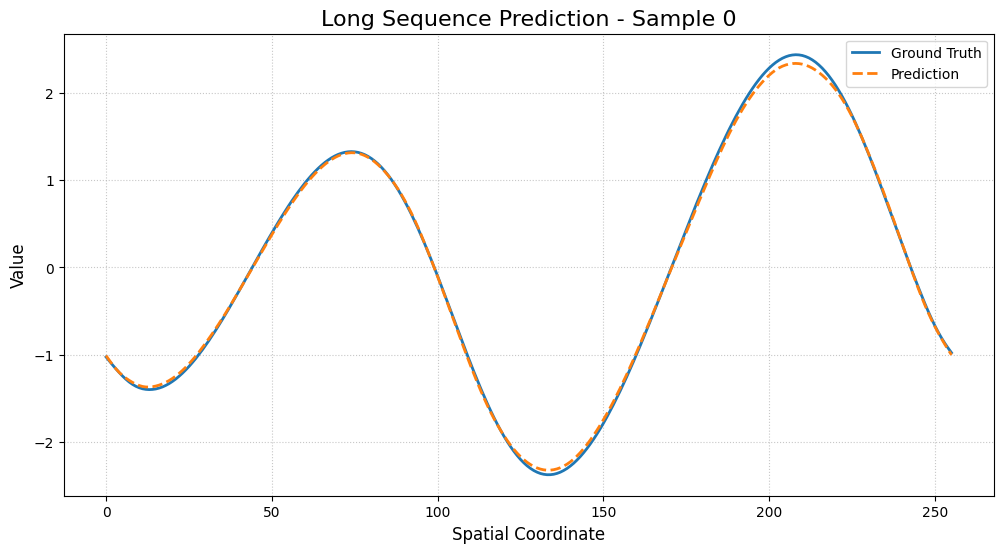


Evaluating single step prediction...


C:\Users\FisherMoon25\AppData\Local\Temp\ipykernel_4172\1470594542.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


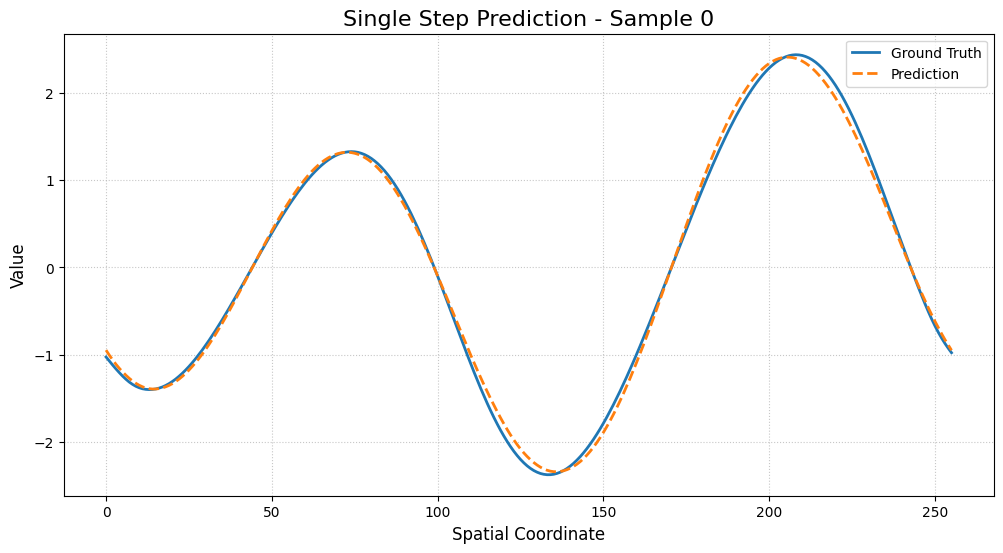

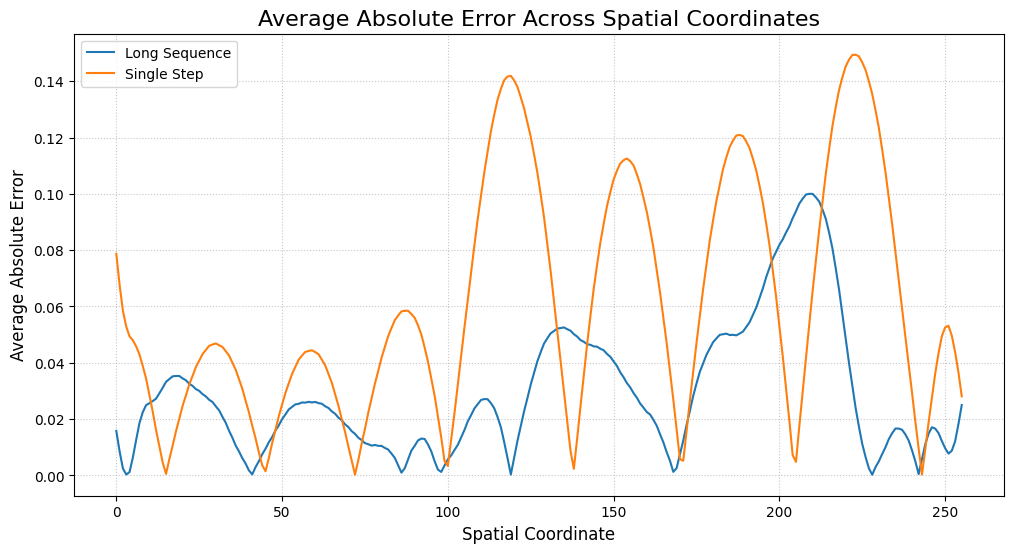

Visualization complete. Check the generated PNG files for detailed plots.


In [27]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns

def load_and_prepare_data(test_initial_conditions, test_solutions, time_steps_to_predict, device):
    test_initial_conditions_tensor = torch.tensor(test_initial_conditions, dtype=torch.float32)
    test_solutions_tensor = torch.tensor(test_solutions[:, time_steps_to_predict-1, :], dtype=torch.float32)
    test_dataset = TensorDataset(test_initial_conditions_tensor, test_solutions_tensor)
    return DataLoader(test_dataset, batch_size=1, shuffle=False)

def load_model(model_path, device):
    model = FNO1d(modes=32, width=64, input_channels=2, output_channels=1).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

def predict_long_sequence(model, inputs, time_steps_to_predict, device):
    predictions = []
    grid = torch.linspace(0, L, inputs.shape[1]).unsqueeze(0).unsqueeze(-1).to(device)
    current_input = torch.cat((inputs.unsqueeze(-1), grid.expand_as(inputs.unsqueeze(-1))), dim=-1)
    
    with torch.no_grad():
        while len(predictions) * 20 < time_steps_to_predict:
            outputs = model(current_input).squeeze().cpu().numpy()
            predictions.append(outputs)
            last_output = outputs[-1]
            last_output_tensor = torch.tensor(last_output, dtype=torch.float32).to(device).unsqueeze(0).unsqueeze(-1)
            current_input = torch.cat((last_output_tensor, grid.expand_as(last_output_tensor)), dim=-1)
    
    return np.concatenate(predictions, axis=0)[:time_steps_to_predict]

def predict_single_step(model, inputs, device):
    with torch.no_grad():
        grid = torch.linspace(0, L, inputs.shape[1]).unsqueeze(0).unsqueeze(-1).to(device)
        inputs = torch.cat((inputs.unsqueeze(-1), grid.expand_as(inputs.unsqueeze(-1))), dim=-1)
        return model(inputs).squeeze().cpu().numpy()

def plot_comparison(ground_truth, prediction, title, save_path=None):
    plt.figure(figsize=(12, 6))
    plt.plot(ground_truth, label="Ground Truth", linewidth=2)
    plt.plot(prediction, label="Prediction", linewidth=2, linestyle='--')
    plt.title(title, fontsize=16)
    plt.xlabel("Spatial Coordinate", fontsize=12)
    plt.ylabel("Value", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle=':', alpha=0.7)
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_error_heatmap(ground_truth, predictions, title, save_path=None):
    error = np.abs(ground_truth - predictions)
    plt.figure(figsize=(12, 6))
    sns.heatmap(error.T, cmap='viridis', cbar_kws={'label': 'Absolute Error'})
    plt.title(title, fontsize=16)
    plt.xlabel("Time Step", fontsize=12)
    plt.ylabel("Spatial Coordinate", fontsize=12)
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

time_steps_to_predict = 10
# Long sequence prediction
print("Evaluating long sequence prediction...")
test_loader_sequence = load_and_prepare_data(test_initial_conditions, test_solutions, time_steps_to_predict, device)

model_sequence = FNO1d(modes=32, width=64, input_channels=2, output_channels=20).to(device)
model_sequence.load_state_dict(torch.load('fno_model_sequence_sobolev.pth'))
model_sequence.eval()
all_predictions_long = []
all_targets_long = []

for inputs, targets in test_loader_sequence:
    inputs, targets = inputs.to(device), targets.to(device)
    predictions = predict_long_sequence(model_sequence, inputs,time_steps_to_predict, device)
    all_predictions_long.append(predictions[-1])
    all_targets_long.append(targets.squeeze().cpu().numpy())

all_predictions_long = np.array(all_predictions_long)
all_targets_long = np.array(all_targets_long)

for idx in range(1):
    plot_comparison(all_targets_long[idx], all_predictions_long[idx], 
                    f"Long Sequence Prediction - Sample {idx}", 
                    f"long_sequence_comparison_{idx}.png")

#plot_error_heatmap(all_targets_long[0], all_predictions_long[0], 
#                   "Error Heatmap - Long Sequence Prediction",
#                   "long_sequence_error_heatmap.png")

# Single step prediction
print("\nEvaluating single step prediction...")
test_loader_single = load_and_prepare_data(test_initial_conditions, test_solutions, time_steps_to_predict, device)
model_single = load_model('fno_model_single_step_sobolev.pth', device)

all_predictions_single = []
all_targets_single = []

for inputs, targets in test_loader_single:
    inputs, targets = inputs.to(device), targets.to(device)
    predictions = predict_single_step(model_single, inputs, device)
    all_predictions_single.append(predictions)
    all_targets_single.append(targets.squeeze().cpu().numpy())

all_predictions_single = np.array(all_predictions_single)
all_targets_single = np.array(all_targets_single)

for idx in range(1):
    plot_comparison(all_targets_single[idx], all_predictions_single[idx], 
                    f"Single Step Prediction - Sample {idx}",
                    f"single_step_comparison_{idx}.png")

#plot_error_heatmap(all_targets_single[0], all_predictions_single[0], 
#                   "Error Heatmap - Single Step Prediction",
#                   "single_step_error_heatmap.png")


plt.figure(figsize=(12, 6))
plt.plot(np.mean(np.abs(all_targets_long - all_predictions_long), axis=0), label="Long Sequence")
plt.plot(np.mean(np.abs(all_targets_single - all_predictions_single), axis=0), label="Single Step")
plt.title("Average Absolute Error Across Spatial Coordinates", fontsize=16)
plt.xlabel("Spatial Coordinate", fontsize=12)
plt.ylabel("Average Absolute Error", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle=':', alpha=0.7)
plt.savefig("average_error_comparison.png", dpi=300, bbox_inches='tight')
plt.show()



Single Step - Predictions shape: (1, 2000, 256)
Single Step - Targets shape: (1, 2000, 256)


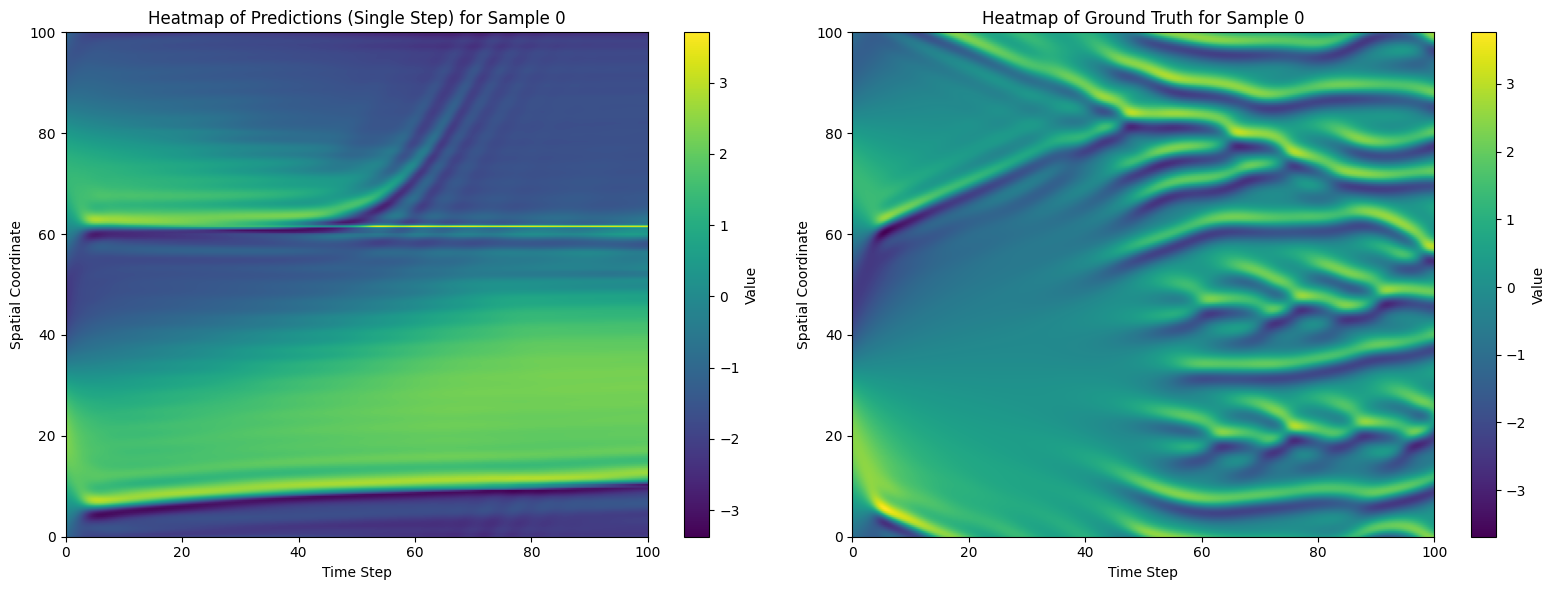

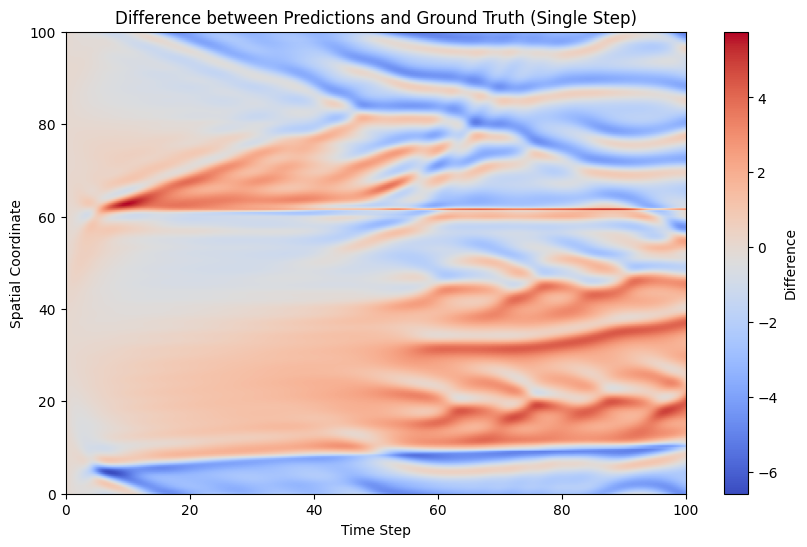

Sequence - Predictions shape: (1, 2000, 256)
Sequence - Targets shape: (1, 2000, 256)


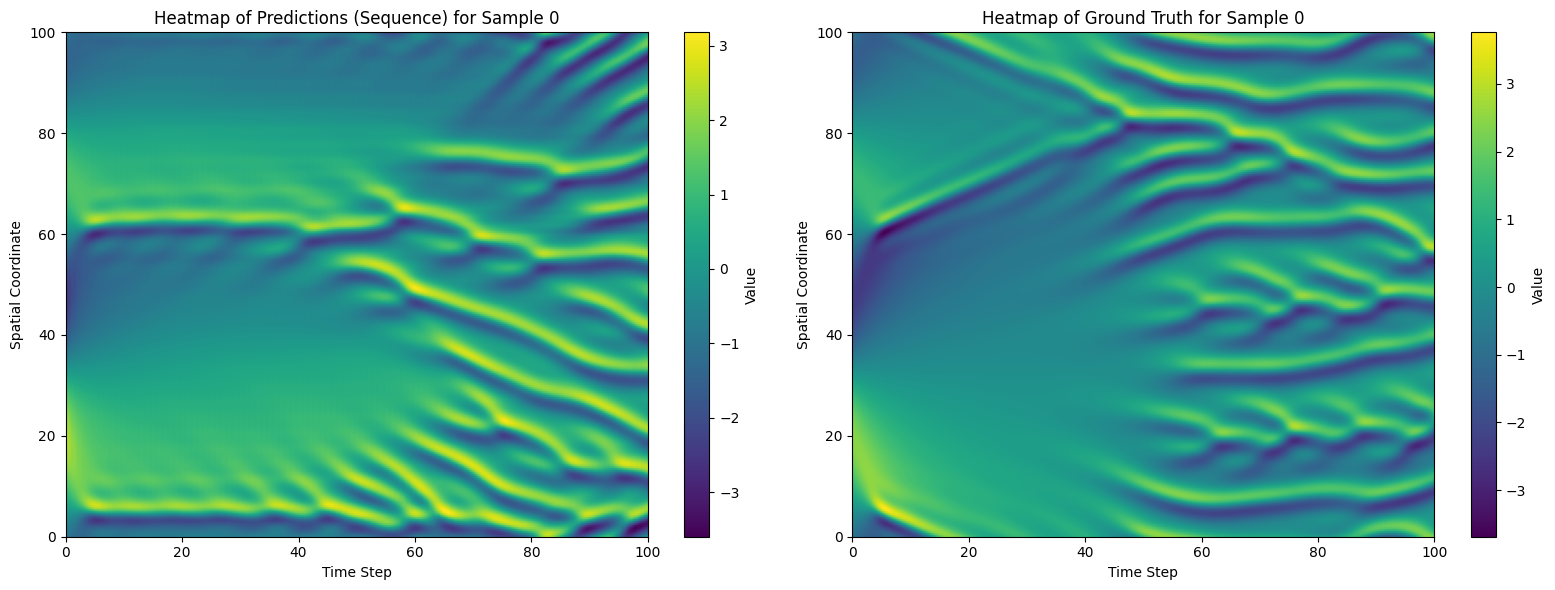

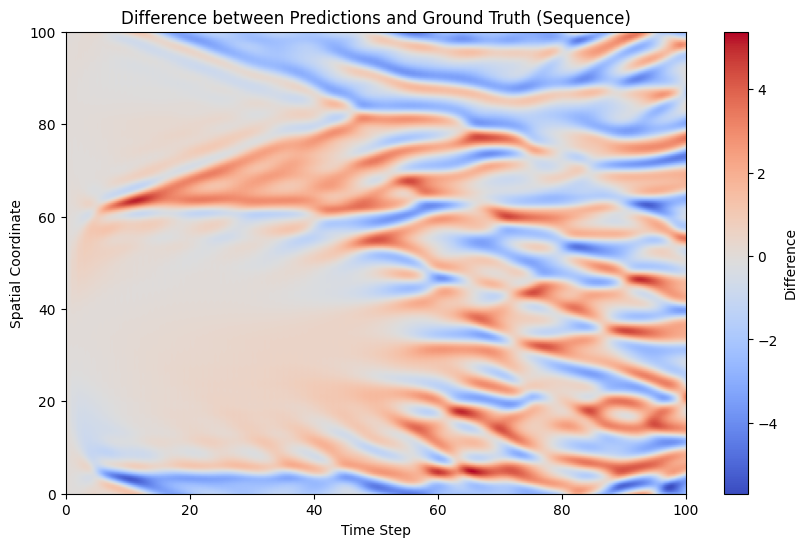

In [28]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt



def plot_heatmaps(predictions, targets, idx, model_name, time_steps, L):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Plot predictions
    ax = axes[0]
    cax = ax.imshow(predictions.T, aspect='auto', cmap='viridis',
                    extent=[0, 0.05*time_steps, 0, L])
    ax.set_title(f"Heatmap of Predictions ({model_name}) for Sample {idx}")
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Spatial Coordinate")
    fig.colorbar(cax, ax=ax, label='Value')

    # Plot ground truth
    ax = axes[1]
    cax = ax.imshow(targets.T, aspect='auto', cmap='viridis',
                    extent=[0, 0.05*time_steps, 0, L])
    ax.set_title(f"Heatmap of Ground Truth for Sample {idx}")
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Spatial Coordinate")
    fig.colorbar(cax, ax=ax, label='Value')

    plt.tight_layout()
    plt.savefig(f"{model_name}_heatmap_sample_{idx}.png", dpi=300, bbox_inches='tight')
    plt.show()

def predict_single_step_sequence(model, initial_input, time_steps, device):
    predictions = []
    current_input = initial_input

    for _ in range(time_steps):
        prediction = predict_single_step(model, current_input, device)
        predictions.append(prediction)
        current_input = torch.tensor(prediction, dtype=torch.float32).unsqueeze(0).to(device)

    return np.array(predictions)

L = 100  
time_steps = 2000

def load_and_prepare_heatmap_data(test_initial_conditions, test_solutions, time_steps, device):
    test_initial_conditions_tensor = torch.tensor(test_initial_conditions, dtype=torch.float32)
    test_solutions_tensor = torch.tensor(test_solutions[:, :time_steps, :], dtype=torch.float32)
    test_dataset = TensorDataset(test_initial_conditions_tensor, test_solutions_tensor)
    return DataLoader(test_dataset, batch_size=1, shuffle=False)

# Load data
test_loader = load_and_prepare_heatmap_data(test_initial_conditions, test_solutions, time_steps, device)


# Evaluate models
models = {
    "Single Step": model_single,
    "Sequence": model_sequence
}
k = 0 
all_model_predictions = []
all_model_targets = []
for model_name, model in models.items():
    all_predictions = []
    all_targets = []

    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        #grid = torch.linspace(0, L, inputs.shape[1]).unsqueeze(0).unsqueeze(-1).to(device)
        #inputs = torch.cat((inputs.unsqueeze(-1), grid.expand_as(inputs.unsqueeze(-1))), dim=-1)
        if k ==1:
            predictions = predict_long_sequence(model, inputs, time_steps, device)
        else :
            predictions = predict_single_step_sequence(model, inputs,time_steps, device)
            
        all_predictions.append(predictions)
        all_targets.append(targets.squeeze().cpu().numpy())
        
        k+=1
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    all_model_predictions.append(all_predictions)
    all_model_targets.append(all_targets)

    print(f"{model_name} - Predictions shape:", all_predictions.shape)
    print(f"{model_name} - Targets shape:", all_targets.shape)

    plot_heatmaps(all_predictions, all_targets, idx, model_name, time_steps, L)

    # Calculate and plot the difference between predictions and ground truth
    difference = all_predictions - all_targets
    plt.figure(figsize=(10, 6))
    plt.imshow(difference.T, aspect='auto', cmap='coolwarm', 
               extent=[0, 0.05*time_steps, 0, L])
    plt.title(f"Difference between Predictions and Ground Truth ({model_name})")
    plt.xlabel("Time Step")
    plt.ylabel("Spatial Coordinate")
    plt.colorbar(label='Difference')
    plt.show()




Analyzing correlations for Single Step Model
Predictions shape: (1, 2000, 256)
References shape: (1, 2000, 256)


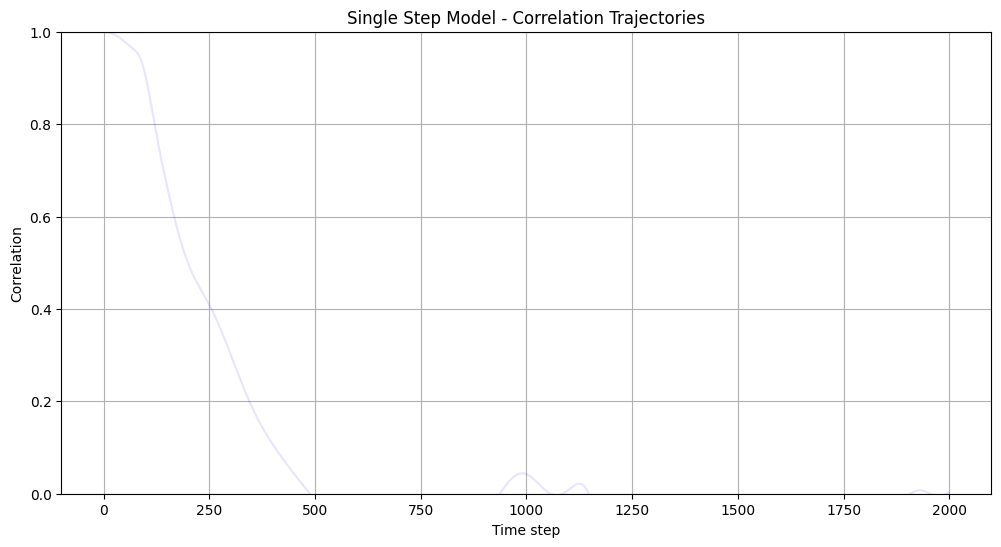


Correlation Statistics for Single Step Model:
Mean correlation: 0.0675
Standard deviation of correlation: 0.2862
Minimum correlation: -0.1350
Maximum correlation: 1.0000

Lowest mean correlation at time step: 1325
Highest mean correlation at time step: 0

Analyzing correlations for Sequence Model
Predictions shape: (1, 2000, 256)
References shape: (1, 2000, 256)


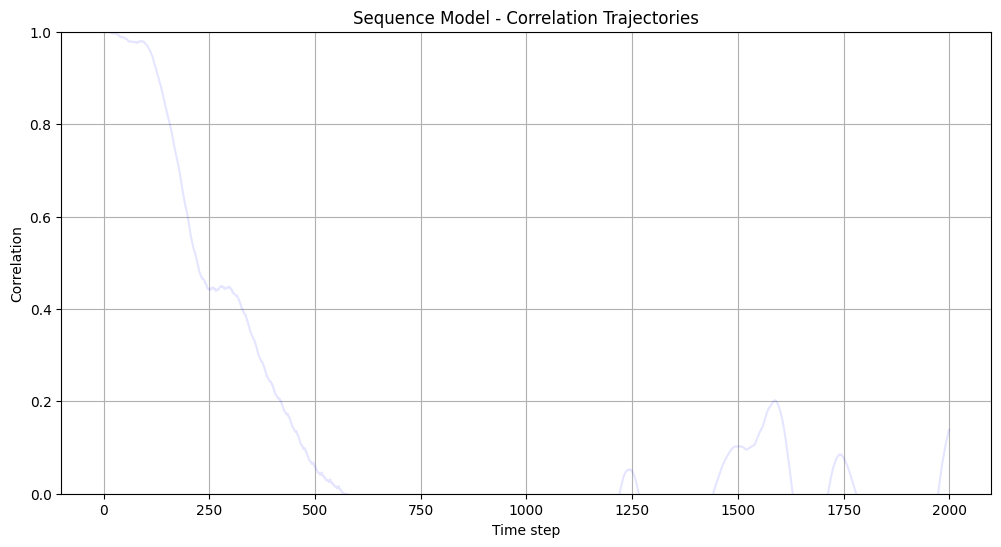


Correlation Statistics for Sequence Model:
Mean correlation: 0.0680
Standard deviation of correlation: 0.3403
Minimum correlation: -0.4181
Maximum correlation: 1.0000

Lowest mean correlation at time step: 1879
Highest mean correlation at time step: 0


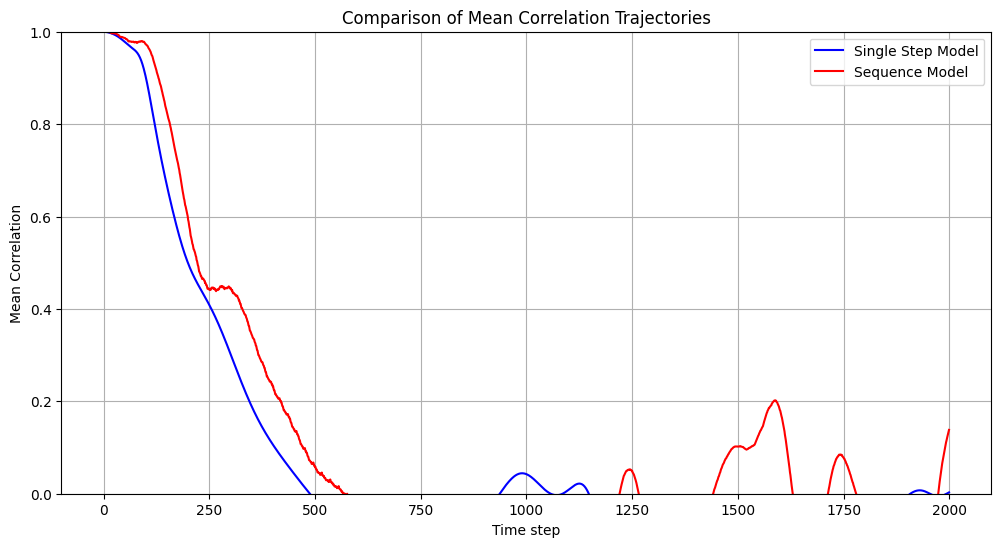

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem

def correlation(pred, ref):
    pred_normalized = pred / np.linalg.norm(pred)
    ref_normalized = ref / np.linalg.norm(ref)
    return np.dot(pred_normalized.flatten(), ref_normalized.flatten())

def compute_correlation_trajectories(predictions, references):
    corr_trajectories = np.zeros((predictions.shape[0], predictions.shape[1]))
    for i in range(predictions.shape[0]):
        for j in range(predictions.shape[1]):
            corr_trajectories[i, j] = correlation(predictions[i, j], references[i, j])
    return corr_trajectories

def plot_correlation_trajectories(corr_trajectories, title):
    plt.figure(figsize=(12, 6))
    plt.plot(corr_trajectories.T, alpha=0.1, color='blue')
    plt.ylim(0, 1)
    plt.title(f"{title} - Correlation Trajectories")
    plt.xlabel("Time step")
    plt.ylabel("Correlation")
    plt.grid(True)
    plt.show()

def plot_mean_correlation_trajectory(corr_trajectories, title):
    mean_corr_trj = np.mean(corr_trajectories, axis=0)
    std_corr_trj = np.std(corr_trajectories, axis=0)
    sem_corr_trj = sem(corr_trajectories, axis=0)

    plt.figure(figsize=(12, 6))
    plt.plot(mean_corr_trj, color='red', linewidth=2, label='Mean')
    plt.fill_between(range(len(mean_corr_trj)), 
                     mean_corr_trj - std_corr_trj, 
                     mean_corr_trj + std_corr_trj, 
                     alpha=0.3, color='red', label='±1 Std Dev')
    plt.fill_between(range(len(mean_corr_trj)), 
                     mean_corr_trj - sem_corr_trj, 
                     mean_corr_trj + sem_corr_trj, 
                     alpha=0.5, color='red', label='±1 SEM')
    plt.ylim(0, 1)
    plt.title(f"{title} - Mean Correlation Trajectory")
    plt.xlabel("Time step")
    plt.ylabel("Mean Correlation")
    plt.legend()
    plt.grid(True)
    plt.show()

def analyze_correlations(predictions, references, title):
    print(f"\nAnalyzing correlations for {title}")
    print(f"Predictions shape: {predictions.shape}")
    print(f"References shape: {references.shape}")

    corr_trajectories = compute_correlation_trajectories(predictions, references)
    
    plot_correlation_trajectories(corr_trajectories, title)
    if num_samples > 1:
        plot_mean_correlation_trajectory(corr_trajectories, title)

    mean_corr = np.mean(corr_trajectories)
   
    
    print(f"\nCorrelation Statistics for {title}:")
    print(f"Mean correlation: {mean_corr:.4f}")


    return corr_trajectories

single_step_corr = analyze_correlations(all_model_predictions[0], all_model_targets[0], "Single Step Model")
sequence_corr = analyze_correlations(all_model_predictions[1], all_model_targets[1] ,"Sequence Model")

# Compare the two models
plt.figure(figsize=(12, 6))
plt.plot(np.mean(single_step_corr, axis=0), label='Single Step Model', color='blue')
plt.plot(np.mean(sequence_corr, axis=0), label='Sequence Model', color='red')
plt.ylim(0, 1)
plt.title("Comparison of Mean Correlation Trajectories")
plt.xlabel("Time step")
plt.ylabel("Mean Correlation")
plt.legend()
plt.grid(True)
plt.show()




# Combinaison des normes de Sobolev et L2

   - La norme L2 capture l'erreur globale en termes d'amplitude.
   - La norme de Sobolev capture la régularité et les variations locales, améliorant potentiellement la stabilité de l'apprentissage et la robustesse du modèle face aux erreurs à différentes échelles.
   En les combinant, on peut obtenir une mesure plus complète de la qualité de la prédiction.
   De plus, cette combinaison peut être vue comme une forme de régularisation, encourageant des solutions plus lisses


> **Contexte** : Cette méthode est appliquée dans le cadre de prédictions de séquences (t+1,t+2,....,t+20).


In [31]:
class CombinedLoss(nn.Module):
    def __init__(self, sobolev_weight=1.0, mse_weight=0.1,k=1):
        super().__init__()
        self.sobolev_loss = SobolevLossFourier( k)
        self.mse_loss = nn.MSELoss()
        self.sobolev_weight = sobolev_weight
        self.mse_weight = mse_weight

    def forward(self, pred, target):
        sobolev = self.sobolev_loss(pred, target)
        mse = self.mse_loss(pred, target)
        return self.sobolev_weight * sobolev + self.mse_weight * mse



In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from tqdm import tqdm

def train_fno_combined(model, train_loader, val_loader, num_epochs, device,k ):
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
    scheduler = OneCycleLR(optimizer, max_lr=0.0001, epochs=num_epochs, steps_per_epoch=len(train_loader))
    criterion = CombinedLoss(sobolev_weight=1,mse_weight=1,k=k)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}")
        for inputs, targets in progress_bar:
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs).squeeze(-1)
           
            loss = criterion(outputs, targets)
            
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            train_loss += loss.item()
            progress_bar.set_postfix({'train_loss': f'{loss.item():.6f}'})
        
        train_loss /= len(train_loader)
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs).squeeze(-1)
                
              
                loss = criterion(outputs, targets)
                
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        
        print(f"\n{'=' * 50}")
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.6f}")
        print(f"Validation Loss: {val_loss:.6f}")
        print(f"{'=' * 50}\n")

    return model

# Configuration
num_epochs = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



Case 2: Sequence prediction (t+1 to t+20)


In [42]:
model_sequence_combined = FNO1d(modes=32, width=64,input_channels=2,output_channels=20).to(device)
print("\nTraining model for sequence prediction (t+1 to t+20)...")
model_sequence_combined = train_fno_combined(model_sequence_combined, train_loader, val_loader, num_epochs, device, k=1)
torch.save(model_sequence_combined.state_dict(), 'fno_model_sequence_combined.pth')


Training model for sequence prediction (t+1 to t+20)...


Epoch 1/30:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1/30: 100%|██████████| 1000/1000 [00:31<00:00, 31.94it/s, train_loss=2.088560]



Epoch 1/30
Train Loss: 3.463499
Validation Loss: 1.982820



Epoch 2/30: 100%|██████████| 1000/1000 [00:29<00:00, 34.35it/s, train_loss=0.102722]



Epoch 2/30
Train Loss: 0.694481
Validation Loss: 0.098671



Epoch 3/30: 100%|██████████| 1000/1000 [00:30<00:00, 32.77it/s, train_loss=0.081924]



Epoch 3/30
Train Loss: 0.099367
Validation Loss: 0.060896



Epoch 4/30: 100%|██████████| 1000/1000 [00:30<00:00, 32.32it/s, train_loss=0.017758]



Epoch 4/30
Train Loss: 0.044585
Validation Loss: 0.017834



Epoch 5/30: 100%|██████████| 1000/1000 [00:29<00:00, 33.47it/s, train_loss=0.002834]



Epoch 5/30
Train Loss: 0.008824
Validation Loss: 0.004270



Epoch 6/30: 100%|██████████| 1000/1000 [00:29<00:00, 33.48it/s, train_loss=0.001501]



Epoch 6/30
Train Loss: 0.003454
Validation Loss: 0.002921



Epoch 7/30: 100%|██████████| 1000/1000 [00:31<00:00, 32.15it/s, train_loss=0.001071]



Epoch 7/30
Train Loss: 0.003009
Validation Loss: 0.002534



Epoch 8/30: 100%|██████████| 1000/1000 [00:29<00:00, 33.42it/s, train_loss=0.001165]



Epoch 8/30
Train Loss: 0.002773
Validation Loss: 0.002436



Epoch 9/30: 100%|██████████| 1000/1000 [00:30<00:00, 32.73it/s, train_loss=0.000955]



Epoch 9/30
Train Loss: 0.002778
Validation Loss: 0.002283



Epoch 10/30: 100%|██████████| 1000/1000 [00:29<00:00, 33.48it/s, train_loss=0.000716]



Epoch 10/30
Train Loss: 0.002293
Validation Loss: 0.002025



Epoch 11/30: 100%|██████████| 1000/1000 [00:29<00:00, 33.63it/s, train_loss=0.000603]



Epoch 11/30
Train Loss: 0.001899
Validation Loss: 0.001975



Epoch 12/30: 100%|██████████| 1000/1000 [00:28<00:00, 34.82it/s, train_loss=0.000533]



Epoch 12/30
Train Loss: 0.001839
Validation Loss: 0.001891



Epoch 13/30: 100%|██████████| 1000/1000 [00:27<00:00, 36.29it/s, train_loss=0.000491]



Epoch 13/30
Train Loss: 0.001758
Validation Loss: 0.001854



Epoch 14/30: 100%|██████████| 1000/1000 [00:27<00:00, 36.28it/s, train_loss=0.000750]



Epoch 14/30
Train Loss: 0.001591
Validation Loss: 0.001973



Epoch 15/30: 100%|██████████| 1000/1000 [00:27<00:00, 36.80it/s, train_loss=0.000533]



Epoch 15/30
Train Loss: 0.001402
Validation Loss: 0.001903



Epoch 16/30: 100%|██████████| 1000/1000 [00:28<00:00, 34.65it/s, train_loss=0.000494]



Epoch 16/30
Train Loss: 0.001341
Validation Loss: 0.001850



Epoch 17/30: 100%|██████████| 1000/1000 [00:32<00:00, 31.10it/s, train_loss=0.000466]



Epoch 17/30
Train Loss: 0.001225
Validation Loss: 0.001793



Epoch 18/30: 100%|██████████| 1000/1000 [00:29<00:00, 33.79it/s, train_loss=0.000478]



Epoch 18/30
Train Loss: 0.001186
Validation Loss: 0.001756



Epoch 19/30: 100%|██████████| 1000/1000 [00:29<00:00, 34.06it/s, train_loss=0.000400]



Epoch 19/30
Train Loss: 0.001122
Validation Loss: 0.001780



Epoch 20/30: 100%|██████████| 1000/1000 [00:33<00:00, 30.28it/s, train_loss=0.000318]



Epoch 20/30
Train Loss: 0.001066
Validation Loss: 0.001691



Epoch 21/30: 100%|██████████| 1000/1000 [00:31<00:00, 31.31it/s, train_loss=0.000336]



Epoch 21/30
Train Loss: 0.001035
Validation Loss: 0.001686



Epoch 22/30: 100%|██████████| 1000/1000 [00:30<00:00, 32.50it/s, train_loss=0.000298]



Epoch 22/30
Train Loss: 0.001013
Validation Loss: 0.001665



Epoch 23/30: 100%|██████████| 1000/1000 [00:33<00:00, 29.91it/s, train_loss=0.000364]



Epoch 23/30
Train Loss: 0.000980
Validation Loss: 0.001768



Epoch 24/30: 100%|██████████| 1000/1000 [00:33<00:00, 29.71it/s, train_loss=0.000338]



Epoch 24/30
Train Loss: 0.000971
Validation Loss: 0.001658



Epoch 25/30: 100%|██████████| 1000/1000 [00:31<00:00, 31.46it/s, train_loss=0.000295]



Epoch 25/30
Train Loss: 0.000952
Validation Loss: 0.001643



Epoch 26/30: 100%|██████████| 1000/1000 [00:30<00:00, 33.23it/s, train_loss=0.000307]



Epoch 26/30
Train Loss: 0.000937
Validation Loss: 0.001658



Epoch 27/30: 100%|██████████| 1000/1000 [00:31<00:00, 31.88it/s, train_loss=0.000283]



Epoch 27/30
Train Loss: 0.000926
Validation Loss: 0.001652



Epoch 28/30: 100%|██████████| 1000/1000 [00:32<00:00, 30.49it/s, train_loss=0.000288]



Epoch 28/30
Train Loss: 0.000922
Validation Loss: 0.001636



Epoch 29/30: 100%|██████████| 1000/1000 [00:30<00:00, 32.50it/s, train_loss=0.000295]



Epoch 29/30
Train Loss: 0.000908
Validation Loss: 0.001632



Epoch 30/30: 100%|██████████| 1000/1000 [00:30<00:00, 32.94it/s, train_loss=0.000267]



Epoch 30/30
Train Loss: 0.000918
Validation Loss: 0.001630



Evaluating long sequence prediction...


C:\Users\FisherMoon25\AppData\Local\Temp\ipykernel_4172\1240460856.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_sequence_combined.load_state_dict(torch.load('fn

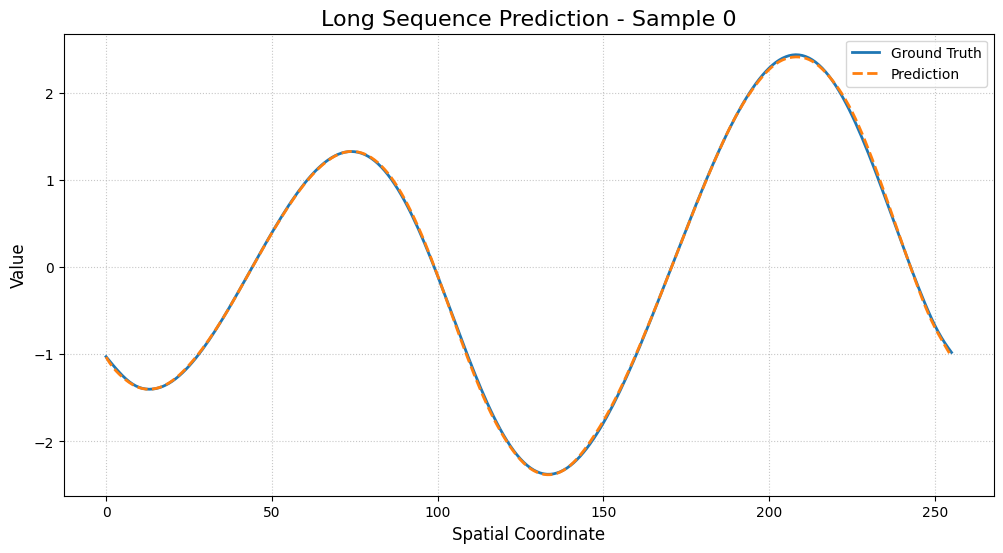

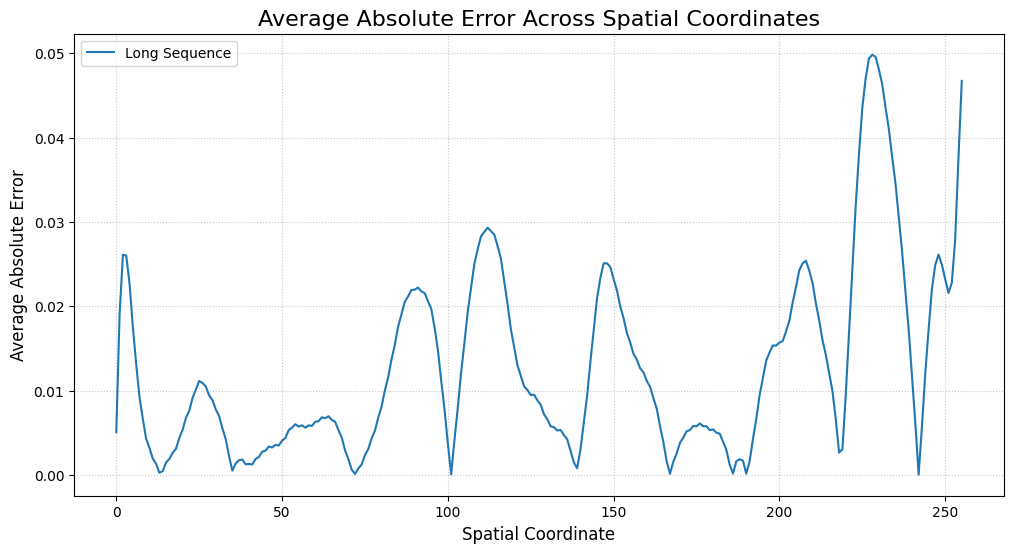

In [49]:

time_steps_to_predict = 10
# Long sequence prediction
print("Evaluating long sequence prediction...")
test_loader_sequence = load_and_prepare_data(test_initial_conditions, test_solutions, time_steps_to_predict, device)
model_sequence_combined = FNO1d(modes=32, width=64, input_channels=2, output_channels=20).to(device)
model_sequence_combined.load_state_dict(torch.load('fno_model_sequence_combined.pth'))
model_sequence_combined.eval()
all_predictions_long = []
all_targets_long = []

for inputs, targets in test_loader_sequence:
    inputs, targets = inputs.to(device), targets.to(device)
    predictions = predict_long_sequence(model_sequence_combined, inputs,time_steps_to_predict, device)
    all_predictions_long.append(predictions[-1])
    all_targets_long.append(targets.squeeze().cpu().numpy())

all_predictions_long = np.array(all_predictions_long)
all_targets_long = np.array(all_targets_long)

for idx in range(1):
    plot_comparison(all_targets_long[idx], all_predictions_long[idx], 
                    f"Long Sequence Prediction - Sample {idx}", 
                    f"long_sequence_comparison_{idx}.png")


# Additional visualizations
plt.figure(figsize=(12, 6))
plt.plot(np.mean(np.abs(all_targets_long - all_predictions_long), axis=0), label="Long Sequence")
plt.title("Average Absolute Error Across Spatial Coordinates", fontsize=16)
plt.xlabel("Spatial Coordinate", fontsize=12)
plt.ylabel("Average Absolute Error", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()



Sequence - Predictions shape: (1, 2000, 256)
Sequence - Targets shape: (1, 2000, 256)


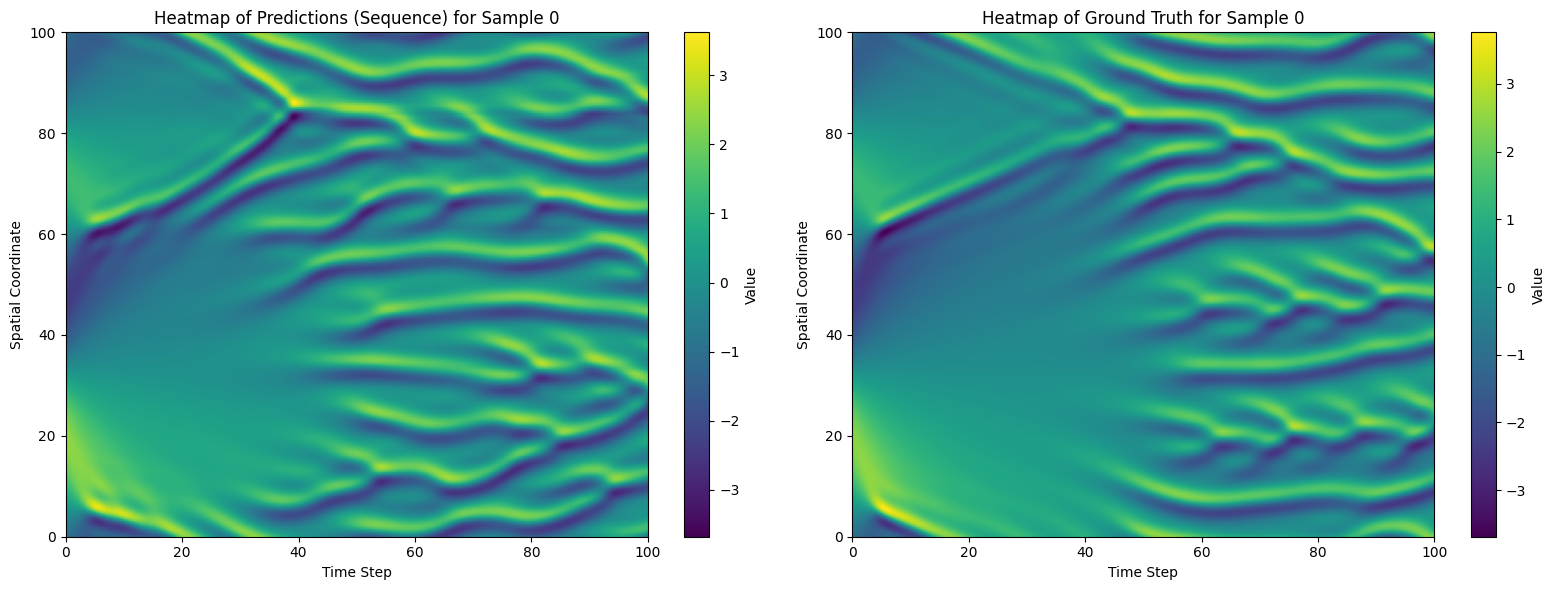

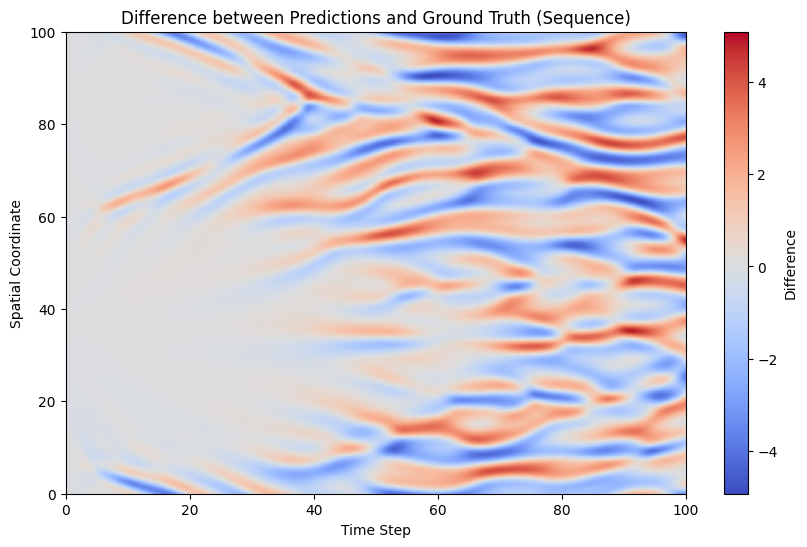

In [50]:

# Evaluate models
models = {
    "Sequence": model_sequence_combined
}
all_model_predictions_combined = []
all_model_targets_combined = []
for model_name, model in models.items():
    all_predictions = []
    all_targets = []

    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        #grid = torch.linspace(0, L, inputs.shape[1]).unsqueeze(0).unsqueeze(-1).to(device)
        #inputs = torch.cat((inputs.unsqueeze(-1), grid.expand_as(inputs.unsqueeze(-1))), dim=-1)
        predictions = predict_long_sequence(model, inputs, time_steps, device)
        
            
        all_predictions.append(predictions)
        all_targets.append(targets.squeeze().cpu().numpy())
        
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    all_model_predictions_combined.append(all_predictions)
    all_model_targets_combined.append(all_targets)

    print(f"{model_name} - Predictions shape:", all_predictions.shape)
    print(f"{model_name} - Targets shape:", all_targets.shape)

    plot_heatmaps(all_predictions, all_targets, idx, model_name, time_steps, L)

    # Calculate and plot the difference between predictions and ground truth
    difference = all_predictions - all_targets
    plt.figure(figsize=(10, 6))
    plt.imshow(difference.T, aspect='auto', cmap='coolwarm', 
               extent=[0, 0.05*time_steps, 0, L])
    plt.title(f"Difference between Predictions and Ground Truth ({model_name})")
    plt.xlabel("Time Step")
    plt.ylabel("Spatial Coordinate")
    plt.colorbar(label='Difference')
    plt.show()




## Approche

- **Objectif** : Explorer l'impact de la combinaison pondérée des pertes L2 et Sobolev
- **Méthode** : Entraînement de multiples modèles FNO avec différents poids de Sobolev

## Fonction de perte

```
Perte totale = α * Perte L2 + β * Perte Sobolev
```
où `α + β = 1` et `β` varie de 0 à 1

## Processus

1. Entraîner des modèles pour chaque valeur de β
2. Évaluer les performances sur l'ensemble de validation
3. Identifier le β optimal (erreur de validation minimale)

## Avantages

- Équilibre entre :
  - Précision globale (Perte L2)
  - Fidélité aux propriétés de régularité (Perte Sobolev)

## Piste d'amélioration

> **Idée** : Paramétrisation plus fine de la norme de Sobolev

```
Perte Sobolev affinée = w₁ * L2 + w₂ * ‖∇f‖² + w₃ * ‖∇²f‖² + ...
```

- **Avantage** : Contrôle précis de chaque composante de régularité
- **Potentiel** : Meilleure adaptation aux spécificités du problème étudié


Training with Sobolev weight: 0.00
Epoch 10, Sobolev Weight 0.00: Train Loss: 0.004166
Epoch 20, Sobolev Weight 0.00: Train Loss: 0.000870
Epoch 30, Sobolev Weight 0.00: Train Loss: 0.000642
Model saved to sobolev_models/fno_sobolev_weight_0.00.pth
Validation Loss: 0.000094

Training with Sobolev weight: 0.10
Epoch 10, Sobolev Weight 0.10: Train Loss: 0.006093
Epoch 20, Sobolev Weight 0.10: Train Loss: 0.001070
Epoch 30, Sobolev Weight 0.10: Train Loss: 0.000727
Model saved to sobolev_models/fno_sobolev_weight_0.10.pth
Validation Loss: 0.000090

Training with Sobolev weight: 0.20
Epoch 10, Sobolev Weight 0.20: Train Loss: 0.003974
Epoch 20, Sobolev Weight 0.20: Train Loss: 0.000905
Epoch 30, Sobolev Weight 0.20: Train Loss: 0.000762
Model saved to sobolev_models/fno_sobolev_weight_0.20.pth
Validation Loss: 0.000063

Training with Sobolev weight: 0.30
Epoch 10, Sobolev Weight 0.30: Train Loss: 0.003960
Epoch 20, Sobolev Weight 0.30: Train Loss: 0.000967
Epoch 30, Sobolev Weight 0.30: T

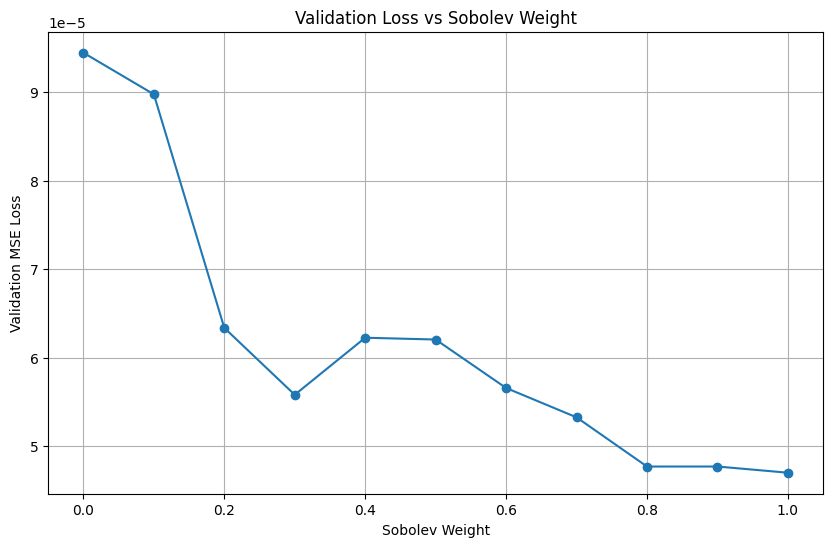


Optimal Sobolev weight: 1.00
Corresponding validation loss: 0.000047
Results saved to sobolev_results.txt


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
import numpy as np
import matplotlib.pyplot as plt
import os

# Create a directory to save models 
os.makedirs('sobolev_models', exist_ok=True)

num_epochs = 30
def train_and_evaluate(sobolev_weight):
    model_sobolev = FNO1d(modes=32, width=64,input_channels=2,output_channels=20).to(device)
    optimizer = optim.Adam(model_sobolev.parameters(), lr=0.0001, weight_decay=1e-5)
    scheduler = OneCycleLR(optimizer, max_lr=0.0001, epochs=num_epochs, steps_per_epoch=len(train_loader))
    sobolev_criterion = CombinedLoss(sobolev_weight=sobolev_weight, mse_weight=1.0)
    mse_criterion = nn.MSELoss()

    for epoch in range(num_epochs):
        model_sobolev.train()
        train_loss = 0.0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model_sobolev(inputs)
            loss = sobolev_criterion(outputs, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model_sobolev.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}, Sobolev Weight {sobolev_weight:.2f}: Train Loss: {train_loss:.6f}')

    # Evaluation
    model_sobolev.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model_sobolev(inputs)
            loss = mse_criterion(outputs, targets)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    
    # Save the model
    model_path = f'sobolev_models/fno_sobolev_weight_{sobolev_weight:.2f}.pth'
    torch.save(model_sobolev.state_dict(), model_path)
    print(f"Model saved to {model_path}")
    
    return val_loss

# Test different Sobolev weights
sobolev_weights = np.linspace(0, 1, 11)  # 11 points from 0 to 1
val_losses = []

for weight in sobolev_weights:
    print(f"\nTraining with Sobolev weight: {weight:.2f}")
    val_loss = train_and_evaluate(weight)
    val_losses.append(val_loss)
    print(f"Validation Loss: {val_loss:.6f}")

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(sobolev_weights, val_losses, marker='o')
plt.xlabel('Sobolev Weight')
plt.ylabel('Validation MSE Loss')
plt.title('Validation Loss vs Sobolev Weight')
plt.grid(True)
plt.savefig('sobolev_weight_vs_loss.png')
plt.show()

# Find and print the optimal Sobolev weight
optimal_weight = sobolev_weights[np.argmin(val_losses)]
print(f"\nOptimal Sobolev weight: {optimal_weight:.2f}")
print(f"Corresponding validation loss: {min(val_losses):.6f}")

# Save results to a file
results = list(zip(sobolev_weights, val_losses))
with open('sobolev_results.txt', 'w') as f:
    f.write("Sobolev Weight, Validation Loss\n")
    for weight, loss in results:
        f.write(f"{weight:.2f}, {loss:.6f}\n")
print("Results saved to sobolev_results.txt")

Coefficient of l2 loss varies 


Training with Mse weight: 0.00
Epoch 10, Sobolev Weight 0.00: Train Loss: 0.000992
Epoch 20, Sobolev Weight 0.00: Train Loss: 0.000744
Epoch 30, Sobolev Weight 0.00: Train Loss: 0.000671
Model saved to sobolev_models/fno_sobolev_weight_sobfix0.00.pth
Validation Loss: 0.000080

Training with Mse weight: 0.10
Epoch 10, Sobolev Weight 0.10: Train Loss: 0.001326
Epoch 20, Sobolev Weight 0.10: Train Loss: 0.000799
Epoch 30, Sobolev Weight 0.10: Train Loss: 0.000721
Model saved to sobolev_models/fno_sobolev_weight_sobfix0.10.pth
Validation Loss: 0.000054

Training with Mse weight: 0.20
Epoch 10, Sobolev Weight 0.20: Train Loss: 0.002245
Epoch 20, Sobolev Weight 0.20: Train Loss: 0.000935
Epoch 30, Sobolev Weight 0.20: Train Loss: 0.000828
Model saved to sobolev_models/fno_sobolev_weight_sobfix0.20.pth
Validation Loss: 0.000063

Training with Mse weight: 0.30
Epoch 10, Sobolev Weight 0.30: Train Loss: 0.003122
Epoch 20, Sobolev Weight 0.30: Train Loss: 0.001084
Epoch 30, Sobolev Weight 0.30:

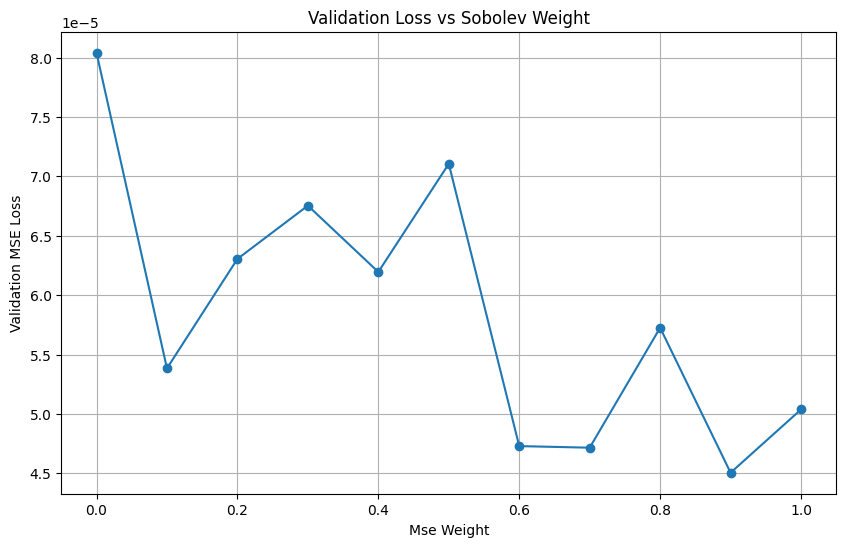


Optimal Mse weight: 0.90
Corresponding validation loss: 0.000045
Results saved to sobolev_results.txt


In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
import numpy as np
import matplotlib.pyplot as plt
import os

# Create a directory to save models if it doesn't exist
os.makedirs('sobolev_models', exist_ok=True)

num_epochs = 30
def train_and_evaluate(sobolev_weight):
    model_sobolev = FNO1d(modes=32, width=64).to(device)
    optimizer = optim.Adam(model_sobolev.parameters(), lr=0.0001, weight_decay=1e-5)
    scheduler = OneCycleLR(optimizer, max_lr=0.0001, epochs=num_epochs, steps_per_epoch=len(train_loader))
    sobolev_criterion = CombinedLoss(sobolev_weight=1.0, mse_weight=sobolev_weight)
    mse_criterion = nn.MSELoss()

    for epoch in range(num_epochs):
        model_sobolev.train()
        train_loss = 0.0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model_sobolev(inputs)
            loss = sobolev_criterion(outputs, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model_sobolev.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}, Sobolev Weight {sobolev_weight:.2f}: Train Loss: {train_loss:.6f}')

    # Evaluation
    model_sobolev.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model_sobolev(inputs)
            loss = mse_criterion(outputs, targets)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    
    # Save the model
    model_path = f'sobolev_models/fno_sobolev_weight_sobfix{sobolev_weight:.2f}.pth'
    torch.save(model_sobolev.state_dict(), model_path)
    print(f"Model saved to {model_path}")
    
    return val_loss

# Test different Sobolev weights
sobolev_weights = np.linspace(0, 1, 11)  # 11 points from 0 to 1
val_losses = []

for weight in sobolev_weights:
    print(f"\nTraining with Mse weight: {weight:.2f}")
    val_loss = train_and_evaluate(weight)
    val_losses.append(val_loss)
    print(f"Validation Loss: {val_loss:.6f}")

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(sobolev_weights, val_losses, marker='o')
plt.xlabel('Mse Weight')
plt.ylabel('Validation MSE Loss')
plt.title('Validation Loss vs Sobolev Weight')
plt.grid(True)
plt.savefig('mse_weight_vs_loss.png')
plt.show()

# Find and print the optimal Sobolev weight
optimal_weight = sobolev_weights[np.argmin(val_losses)]
print(f"\nOptimal Mse weight: {optimal_weight:.2f}")
print(f"Corresponding validation loss: {min(val_losses):.6f}")

# Save results to a file
results = list(zip(sobolev_weights, val_losses))
with open('sobolev_results.txt', 'w') as f:
    f.write("Sobolev Weight, Validation Loss\n")
    for weight, loss in results:
        f.write(f"{weight:.2f}, {loss:.6f}\n")
print("Results saved to sobolev_results.txt")

In [13]:
# Generate test dataset

# Parameters
L = 100
N = 256
T = 100
num_time_steps = 200
tol = 1e-6
num_samples = 1
def generate_dataset_test(num_samples: int, L: int, N: int, T: float, num_time_steps: int, tol: float, output_dir: str):
    x = np.linspace(0,  L, N)
    t = np.arange(0, T+0.05, 0.05)

    initial_conditions_list = []
    solutions_list = []

    for i in range(num_samples):
        u0 = initial_conditions(x, L)
        sol_ps = solve_ivp(fun=pseudospectral, t_span=[t[0], t[-1]], y0=u0, method='Radau', t_eval=t, args=(L,), atol=tol, rtol=tol)
        initial_conditions_list.append(u0)
        solutions_list.append(sol_ps.y.T)
        if i % 10 == 0:
            print(f"Generated {i} samples")

    initial_conditions_array = np.array(initial_conditions_list)
    max_len = max([sol.shape[0] for sol in solutions_list])
    solutions_array = np.zeros((num_samples, max_len, N))
    for i, sol in enumerate(solutions_list):
        solutions_array[i, :sol.shape[0], :] = sol

    return initial_conditions_array, solutions_array

test_initial_conditions, test_solutions = generate_dataset_test(3, L, N, T, num_time_steps, tol, output_dir)
# Generate validation dataset
#aggregate_datasets(1, 100, dt, L, N, output_dir, 'test')
#test_inputs = np.load(os.path.join(output_dir, 'test_inputs.npy'))
#test_outputs = np.load(os.path.join(output_dir, 'test_outputs.npy'))

#sampled_inputs_test, sampled_outputs_test = sample_uniformly(test_inputs, test_outputs, 1)





Generated 0 samples


TEST THE DIFFERENT MODELS 

In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import os

# Parameters
time_steps_to_predict = 200
L = 100  

test_initial_conditions_tensor = torch.tensor(test_initial_conditions, dtype=torch.float32)
test_solutions_tensor = torch.tensor(test_solutions[:, time_steps_to_predict-1, :], dtype=torch.float32)

test_dataset = TensorDataset(test_initial_conditions_tensor, test_solutions_tensor)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

def evaluate_model(model, device):
    model.eval()
    all_predictions = []
    all_targets = []
    all_inputs = []
    all_pred = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            grid = torch.linspace(0, L, inputs.shape[1]).unsqueeze(0).unsqueeze(-1).to(device)
            inputs = torch.cat((inputs.unsqueeze(-1), grid.expand_as(inputs.unsqueeze(-1))), dim=-1)

            predictions = []
            current_input = inputs
            
            while len(predictions) * 20 < time_steps_to_predict:
                outputs = model(current_input)
                outputs = outputs.squeeze().cpu().numpy()
                predictions.append(outputs)
                last_output = outputs[-1]
                last_output_tensor = torch.tensor(last_output, dtype=torch.float32).to(device)
                last_output_tensor = last_output_tensor.unsqueeze(0).unsqueeze(-1)
                current_input = torch.cat((last_output_tensor, grid.expand_as(last_output_tensor)), dim=-1)

            predictions = np.concatenate(predictions, axis=0)[:time_steps_to_predict]
            targets = targets.squeeze().cpu().numpy()
            inputs = inputs.squeeze().cpu().numpy()
            all_inputs.append(inputs)
            all_predictions.append(predictions[-1])
            all_targets.append(targets)
            all_pred.append(predictions)

    return np.array(all_predictions), np.array(all_targets), np.array(all_pred), all_inputs

# Evaluate all models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_dir = 'sobolev_models'
all_model_results = {}
import re
for model_file in os.listdir(model_dir):
    if model_file.endswith('.pth'):
        try:
            # Try to extract weight using regex
            weight_match = re.search(r'weight_(\d+\.\d+)\.pth$', model_file)
            if weight_match:
                weight = float(weight_match.group(1))
            else:
                print(f"Skipping file {model_file} - unable to extract weight")
                continue        
            
            model_path = os.path.join(model_dir, model_file)
            model = FNO1d(modes=32, width=64).to(device)
            model.load_state_dict(torch.load(model_path))
            predictions, targets, all_pred, inputs = evaluate_model(model, device)
            all_model_results[weight] = (predictions, targets, all_pred, inputs)
        except Exception as e:
            print(f"Error processing file {model_file}: {str(e)}")
        

# Plotting
plt.figure(figsize=(20, 15))
num_samples = 3
num_weights = len(all_model_results)
colors = plt.cm.rainbow(np.linspace(0, 1, num_weights))

for i in range(1):
    plt.subplot(num_samples, 1, i+1)
    for j, (weight, results) in enumerate(sorted(all_model_results.items())):
        predictions, targets, _, _ = results
        if (weight == 0.0 or weight == 1.0) :
         plt.plot(predictions[i], label=f'Weight {weight:.2f}', color=colors[j], alpha=0.7)
    
    plt.plot(targets[i], label='Ground Truth', color='black', linewidth=2)
    plt.title(f'Sample {i+1}')
    plt.xlabel('Spatial Coordinate')
    plt.ylabel('Value')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('all_models_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate and print MSE for each model
for weight, results in sorted(all_model_results.items()):
    predictions, targets, _, _ = results
    mse = np.mean((predictions - targets)**2)
    print(f'Sobolev Weight {weight:.2f}: MSE = {mse:.6f}')

# Find the best model based on MSE
best_weight = min(all_model_results.keys(), key=lambda w: np.mean((all_model_results[w][0] - all_model_results[w][1])**2))
print(f'\nBest model: Sobolev Weight {best_weight:.2f}')

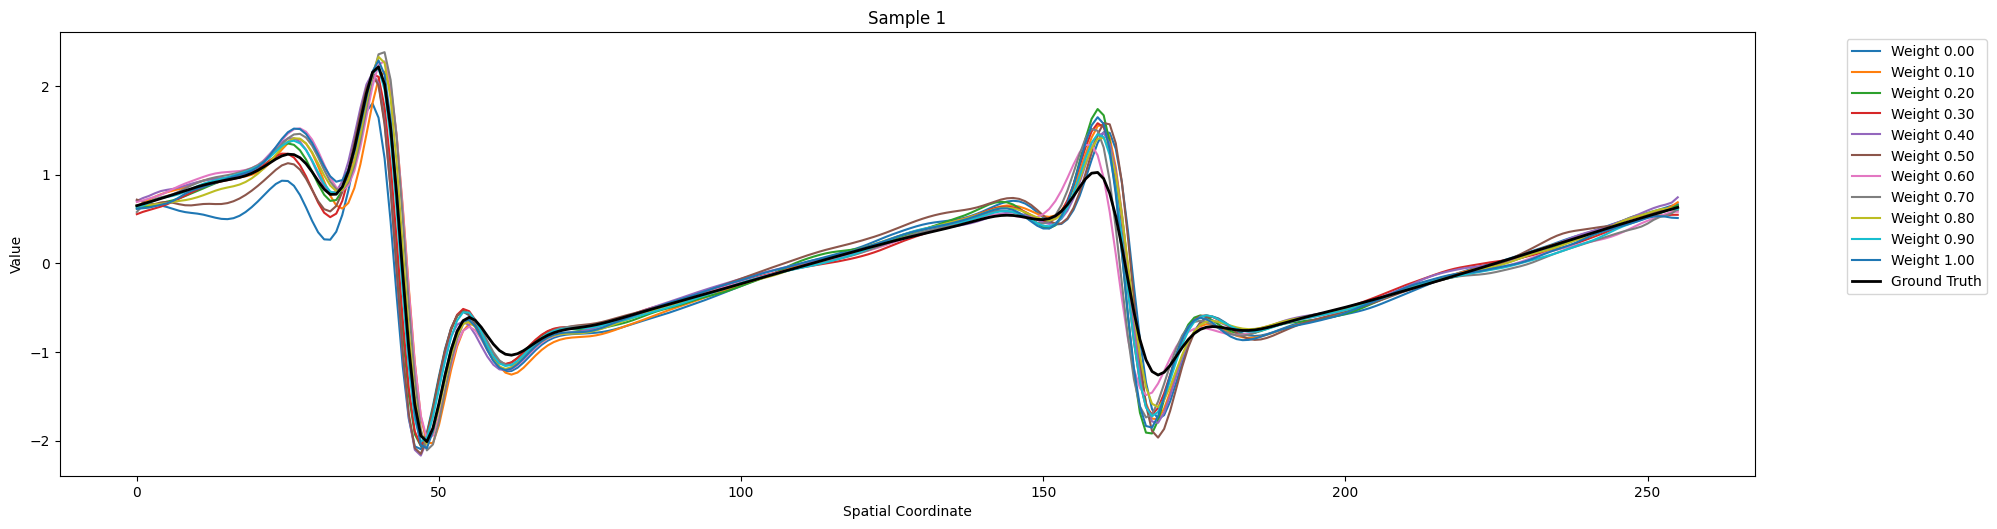

Sobolev Weight 0.00: MSE = 0.087026
Sobolev Weight 0.10: MSE = 0.063640
Sobolev Weight 0.20: MSE = 0.093081
Sobolev Weight 0.30: MSE = 0.061913
Sobolev Weight 0.40: MSE = 0.030866
Sobolev Weight 0.50: MSE = 0.056436
Sobolev Weight 0.60: MSE = 0.061538
Sobolev Weight 0.70: MSE = 0.044940
Sobolev Weight 0.80: MSE = 0.045866
Sobolev Weight 0.90: MSE = 0.039572
Sobolev Weight 1.00: MSE = 0.043211

Best model: Sobolev Weight 0.40


In [48]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import os


# List of model files
model_files = [
    'fno_sobolev_weight_sobfix0.00.pth',
    'fno_sobolev_weight_sobfix0.10.pth',
    'fno_sobolev_weight_sobfix0.20.pth',
    'fno_sobolev_weight_sobfix0.30.pth',
    'fno_sobolev_weight_sobfix0.40.pth',
    'fno_sobolev_weight_sobfix0.50.pth',
    'fno_sobolev_weight_sobfix0.60.pth',
    'fno_sobolev_weight_sobfix0.70.pth',
    'fno_sobolev_weight_sobfix0.80.pth',
    'fno_sobolev_weight_sobfix0.90.pth',
    'fno_sobolev_weight_sobfix1.00.pth'
]

# Evaluate all models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_dir = 'sobolev_models'
all_model_results = {}

for model_file in model_files:
    weight = float(model_file.split('sobfix')[-1].split('.pth')[0])
    model_path = os.path.join(model_dir, model_file)
    model = FNO1d(modes=32, width=64).to(device)
    model.load_state_dict(torch.load(model_path))
    predictions, targets, all_pred, inputs = evaluate_model(model, device)
    all_model_results[weight] = (predictions, targets, all_pred, inputs)

# Plotting
plt.figure(figsize=(20, 15))
num_samples = 3

for i in range(1):
    plt.subplot(num_samples, 1, i+1)
    
    for weight, results in sorted(all_model_results.items()):
        predictions, targets, _, _ = results
        plt.plot(predictions[i], label=f'Weight {weight:.2f}')
    
    plt.plot(targets[i], label='Ground Truth', color='black', linewidth=2)
    plt.title(f'Sample {i+1}')
    plt.xlabel('Spatial Coordinate')
    plt.ylabel('Value')
    
    if i == 0:  
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig('all_models_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate and print MSE for each model
for weight, results in sorted(all_model_results.items()):
    predictions, targets, _, _ = results
    mse = np.mean((predictions - targets)**2)
    print(f'Sobolev Weight {weight:.2f}: MSE = {mse:.6f}')

# Find the best model based on MSE
best_weight = min(all_model_results.keys(), key=lambda w: np.mean((all_model_results[w][0] - all_model_results[w][1])**2))
print(f'\nBest model: Sobolev Weight {best_weight:.2f}')

# Pondération individuelle des termes de la norme de Sobolev

Cette fois-ci, nous avons modifié notre approche en introduisant une pondération individuelle pour chaque terme de la norme de Sobolev. Au lieu de simplement combiner la perte L2 et la perte de Sobolev avec un seul coefficient, nous attribuons maintenant un poids spécifique à chaque composante de la norme de Sobolev 

In [57]:
class SobolevLossFourierWithWeights(nn.Module):
    def __init__(self, k=2, weights=None):
        super(SobolevLossFourierWithWeights, self).__init__()
        self.k = k
        # Si aucun poids n'est fourni, utiliser des poids égaux
        self.weights = weights if weights is not None else [1.0] * (k + 1)
        assert len(self.weights) == k + 1, f"Le nombre de poids doit être {k + 1}"

    def frequency_weights(self, nx):
        k_x = torch.cat((torch.arange(start=0, end=nx//2, step=1),
                         torch.arange(start=-nx//2, end=0, step=1)), 0).reshape(1, nx)
        k_x = torch.abs(k_x)
        weights = self.weights[0] * torch.ones_like(k_x, dtype=torch.float32)
        for i in range(1, self.k + 1):
            weights += self.weights[i] * k_x**(2 * i)
        return weights.unsqueeze(1)  # Shape: (1, 1, nx)

    def compute_loss(self, x, y):
        if x.dim() == 3:
            batch_size, nt, nx = x.shape
        else:
            batch_size, nx = x.shape
            nt = 1
            x = x.unsqueeze(1)
            y = y.unsqueeze(1)

        x_fft = torch.fft.fftn(x, dim=-1)
        y_fft = torch.fft.fftn(y, dim=-1)

        weights = self.frequency_weights(nx).to(x.device)
        weights = weights.repeat(1, nt, 1)  # Repeat for time dimension if necessary

        diff_fft = x_fft - y_fft
        h1_loss = torch.sum(weights * torch.abs(diff_fft)**2,)

        # Normalize by the energy of the target signal
        h1_loss = h1_loss / (torch.sum(weights * torch.abs(y_fft)**2) + 1e-8)

        return h1_loss.mean()

    def forward(self, pred, target):
        return self.compute_loss(pred, target)



In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
import numpy as np
import matplotlib.pyplot as plt
import os

# Create directories to save models and results
os.makedirs('sobolev_models', exist_ok=True)
os.makedirs('results', exist_ok=True)

num_epochs = 30

def train_and_evaluate(l2_weight, grad_weight):
    model_sobolev = FNO1d(modes=32, width=64,input_channels=2,output_channels=20).to(device)
    optimizer = optim.Adam(model_sobolev.parameters(), lr=0.0001, weight_decay=1e-5)
    scheduler = OneCycleLR(optimizer, max_lr=0.0001, epochs=num_epochs, steps_per_epoch=len(train_loader))
    sobolev_criterion = SobolevLossFourierWithWeights(k=1, weights=[l2_weight, grad_weight])
    mse_criterion = nn.MSELoss()

    train_losses, val_mse_losses, val_sobolev_losses = [], [], []

    for epoch in range(num_epochs):
        model_sobolev.train()
        train_loss = 0.0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model_sobolev(inputs)
            loss = sobolev_criterion(outputs, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model_sobolev.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}, L2 Weight {l2_weight:.2f}, Grad Weight {grad_weight:.2f}: Train Loss: {train_loss:.6f}')

        # Validation
        model_sobolev.eval()
        val_mse_loss = 0.0
        val_sobolev_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model_sobolev(inputs)
                val_mse_loss += mse_criterion(outputs, targets).item()
                val_sobolev_loss += sobolev_criterion(outputs, targets).item()

        val_mse_loss /= len(val_loader)
        val_sobolev_loss /= len(val_loader)
        val_mse_losses.append(val_mse_loss)
        val_sobolev_losses.append(val_sobolev_loss)

    # Save the model
    model_path = f'sobolev_models/fno_l2_{l2_weight:.2f}_grad_{grad_weight:.2f}.pth'
    torch.save(model_sobolev.state_dict(), model_path)
    print(f"Model saved to {model_path}")
    
    return train_losses, val_mse_losses, val_sobolev_losses

# Fix L2 weight and test different gradient weights
fixed_l2_weight = 1.0  
grad_weights = np.linspace(0, 2, 21)  
results = []

for grad_w in grad_weights:
    if grad_w == 0:
        continue
    
    print(f"\nTraining with fixed L2 weight: {fixed_l2_weight:.2f}, Gradient weight: {grad_w:.2f}")
    train_losses, val_mse_losses, val_sobolev_losses = train_and_evaluate(fixed_l2_weight, grad_w)
    results.append((fixed_l2_weight, grad_w, train_losses[-1], val_mse_losses[-1], val_sobolev_losses[-1]))

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

l2_w, grad_w, _, val_mse, val_sobolev = zip(*results)

scatter1 = ax1.scatter(l2_w, grad_w, c=val_mse, cmap='viridis')
ax1.set_xlabel('L2 Weight')
ax1.set_ylabel('Gradient Weight')
ax1.set_title('Validation MSE Loss')
plt.colorbar(scatter1, ax=ax1)

scatter2 = ax2.scatter(l2_w, grad_w, c=val_sobolev, cmap='viridis')
ax2.set_xlabel('L2 Weight')
ax2.set_ylabel('Gradient Weight')
ax2.set_title('Validation Sobolev Loss')
plt.colorbar(scatter2, ax=ax2)

plt.tight_layout()
plt.savefig('results/loss_heatmaps.png')
plt.show()

# Find and print the optimal weights
optimal_result = min(results, key=lambda x: x[3])  # Minimize MSE loss
print(f"\nOptimal weights (based on MSE loss):")
print(f"L2 weight: {optimal_result[0]:.2f}")
print(f"Gradient weight: {optimal_result[1]:.2f}")
print(f"Validation MSE loss: {optimal_result[3]:.6f}")
print(f"Validation Sobolev loss: {optimal_result[4]:.6f}")

# Save results to a file
with open('results/sobolev_results.txt', 'w') as f:
    f.write("L2 Weight, Grad Weight, Train Loss, Val MSE Loss, Val Sobolev Loss\n")
    for result in results:
        f.write(f"{result[0]:.2f}, {result[1]:.2f}, {result[2]:.6f}, {result[3]:.6f}, {result[4]:.6f}\n")
print("Results saved to results/sobolev_results.txt")


Training with fixed L2 weight: 1.00, Gradient weight: 0.10
Epoch 10, L2 Weight 1.00, Grad Weight 0.10: Train Loss: 0.001064
Epoch 20, L2 Weight 1.00, Grad Weight 0.10: Train Loss: 0.000573


KeyboardInterrupt: 

: 